In [1]:
import numpy as np
import tensorflow as tf
import os.path
import itertools
import scipy.io as sio
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
# base_npz_path = '/users/jhlee/data/img_snd/'
base_npz_path = '/home/lww/Research/sf_word_recog_research/data/data_speech_commands_v0.02/'

train_data = np.load(os.path.join(base_npz_path, 'train_data.npz'))
test_data = np.load(os.path.join(base_npz_path, 'test_data.npz'))

In [8]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443), (36805,), (4815, 25443), (4815,), (16, 2))

In [17]:
y_dict = {name:int(idx) for name, idx in y_table}
y_dict

{'zero': 0,
 'one': 1,
 'two': 2,
 'three': 3,
 'four': 4,
 'five': 5,
 'six': 6,
 'seven': 7,
 'eight': 8,
 'nine': 9,
 'bed': 10,
 'bird': 11,
 'tree': 12,
 'cat': 13,
 'house': 14,
 'dog': 15}

In [18]:
mean_vals = np.mean(x_train, axis=0)
std_val = np.std(x_train)
x_test_centered = (x_test-mean_vals) / std_val

del x_train, x_test

In [19]:
x_train, y_trainimg_dim = (99, 257)
img_dim_crop = (99, 257)

In [20]:
def batch_generator(X, y, batch_size=64, 
                    shuffle=False, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [21]:
## wrapper functions 

def conv_layer(input_tensor, name,
               kernel_size, n_output_channels, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    with tf.variable_scope(name):
        ## get n_input_channels:
        ##   input tensor shape: 
        ##   [batch x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1] 

        weights_shape = (list(kernel_size) + 
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_channels]))
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor, 
                            filter=weights,
                            strides=strides, 
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases, 
                              name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv)
        
        return conv

In [22]:
def fc_layer(input_tensor, name,
              n_output_units, activation_fn=None):
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, 
                                      shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_units]))
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases,
                              name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer

        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

In [23]:
def build_cnn_1conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv1_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')
    

In [24]:
def build_cnn_1conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv1_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)

   ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')
    

In [25]:
def build_cnn_2conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv2_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

In [26]:
def build_cnn_2conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv2_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)
    ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [27]:
def build_cnn_3conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv3_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    print(keep_prob)
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')
    print(fc1_drop)
    
    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [28]:
def build_cnn_3conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv3_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)
    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)

    ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')



In [29]:
def build_cnn_4conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                   n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv4_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [30]:
def build_cnn_4conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv4_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)

    ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')
    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [31]:
def build_cnn_5conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 5th layer: Conv_5
    print('\nBuilding 5th layer: ')
    conv5 = conv_layer(conv4_pool, name='conv_5',
                    kernel_size=(2,2),
                    padding_mode='VALID',
                    n_output_channels=128)
    ## MaxPooling 
    conv5_pool = tf.nn.max_pool(conv5,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv5_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')
    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [32]:
def build_cnn_5conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(5,5),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 5th layer: Conv_5
    print('\nBuilding 5th layer: ')
    conv5 = conv_layer(conv4_pool, name='conv_5',
                    kernel_size=(2,2),
                    padding_mode='VALID',
                    n_output_channels=128)
    ## MaxPooling 
    conv5_pool = tf.nn.max_pool(conv5,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv5_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)

    ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }
    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [33]:
def build_cnn_6conv_1fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(2, 3),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 5th layer: Conv_5
    print('\nBuilding 5th layer: ')
    conv5 = conv_layer(conv4_pool, name='conv_5',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=128)
    ## MaxPooling 
    conv5_pool = tf.nn.max_pool(conv5,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 6th layer: Conv_6
    print('\nBuilding 6th layer: ')
    conv6 = conv_layer(conv5_pool, name='conv_6',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=256)
    ## MaxPooling 
    conv6_pool = tf.nn.max_pool(conv6,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv6_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc1_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [34]:
def build_cnn_6conv_2fc():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim_crop)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim_crop[0], img_dim_crop[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    conv1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(2, 3),
                    padding_mode='VALID',
                    n_output_channels=8)
    ## MaxPooling
    conv1_pool = tf.nn.max_pool(conv1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    conv2 = conv_layer(conv1_pool, name='conv_2',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=16)
    ## MaxPooling 
    conv2_pool = tf.nn.max_pool(conv2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Conv_3
    print('\nBuilding 3rd layer: ')
    conv3 = conv_layer(conv2_pool, name='conv_3',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling 
    conv3_pool = tf.nn.max_pool(conv3,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 4th layer: Conv_4
    print('\nBuilding 4th layer: ')
    conv4 = conv_layer(conv3_pool, name='conv_4',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    conv4_pool = tf.nn.max_pool(conv4,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 5th layer: Conv_5
    print('\nBuilding 5th layer: ')
    conv5 = conv_layer(conv4_pool, name='conv_5',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=128)
    ## MaxPooling 
    conv5_pool = tf.nn.max_pool(conv5,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 6th layer: Conv_6
    print('\nBuilding 6th layer: ')
    conv6 = conv_layer(conv5_pool, name='conv_6',
                    kernel_size=(2,3),
                    padding_mode='VALID',
                    n_output_channels=256)
    ## MaxPooling 
    conv6_pool = tf.nn.max_pool(conv6,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc1 = fc_layer(conv6_pool, name='fc_1',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
                            name='fc1_dropout_layer')

    ## 1st FC layer: Fully Connected
    print('\nBuilding 1st FC layer:')
    fc2 = fc_layer(fc1_drop, name='fc_2',
                  n_output_units=512,
                  activation_fn=tf.nn.relu)

    ## Dropout
#    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    fc2_drop = tf.nn.dropout(fc2, keep_prob=keep_prob,
                            name='fc2_dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    output_layer = fc_layer(fc2_drop, name='output_layer',
                  n_output_units=16,
                  activation_fn=None)

        ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(output_layer, name='probabilities'),
        'labels' : tf.cast(tf.argmax(output_layer, axis=1), tf.int32,
                           name='labels')
    }

    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=output_layer, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')


In [35]:
def save(saver, sess, epoch, path='./model/'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in {} at epoch# {}'.format(path, epoch))
    saver.save(sess, os.path.join(path,'cnn-model.ckpt'),
               global_step=epoch)


def load(saver, sess, path, epoch):
    print('Loading model from %s' % path)
    saver.restore(sess, os.path.join(
            path, 'cnn-model.ckpt-%d' % epoch))


In [36]:
def train(sess, training_set, validation_set=None, test_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, random_seed=None, path='./model'):

    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []
    train_acc, valid_acc, test_acc = [], [], []

    ## initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # for shuflling in batch_generator
    for epoch in range(1, epochs+1):
        batch_gen = batch_generator(
                        X_data, y_data, batch_size=64,
                        shuffle=shuffle)
        avg_loss = 0.0
        avg_acc = 0.0
        for i,(batch_x,batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x,
                    'tf_y:0': batch_y,
                    'fc_keep_prob:0': dropout}
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss
            avg_acc += sess.run('accuracy:0', feed_dict=feed)

        train_acc.append(avg_acc / (i+1))
        training_loss.append(avg_loss / (i+1))
        print('Epoch %02d Training Avg. Loss: %7.3f, Train Acc: %7.3f,' % (
            epoch, avg_loss, train_acc[-1]), end=' ')


        if validation_set is not None:
            batch_gen_valid = batch_generator(validation_set[0], validation_set[1], \
                        batch_size=64, shuffle=shuffle)
            avg_acc =0.0
            for j, (batch_valid_x, batch_valid_y) in enumerate(batch_gen_valid):

                feed = {'tf_x:0': batch_valid_x, 'tf_y:0': batch_valid_y, \
                        'fc_keep_prob:0':1.0}
                avg_acc += sess.run('accuracy:0', feed_dict=feed)

            valid_acc.append(avg_acc / (j+1))
            print(' Validation Acc: %7.3f,' % valid_acc[-1])

        if test_set is not None:
            batch_gen_test = batch_generator(test_set[0], test_set[1], \
                        batch_size=64, shuffle=shuffle)
            avg_acc = 0.0
            for j, (batch_test_x, batch_test_y) in enumerate(batch_gen_test):

                feed = {'tf_x:0': batch_test_x, 'tf_y:0': batch_test_y, \
                        'fc_keep_prob:0':1.0}
                avg_acc += sess.run('accuracy:0', feed_dict=feed)

            test_acc.append(avg_acc / (j+1))
            print(' Test Acc: %7.3f' % test_acc[-1])

#            feed = {'tf_x:0': validation_set[0],
#                    'tf_y:0': validation_set[1],
#                    'fc_keep_prob:0':1.0}
#            valid_acc = sess.run('accuracy:0', feed_dict=feed)
#            print(' Validation Acc: %7.3f' % valid_acc)
        else:
            print()

        if epoch % 10 == 0:
            save(saver, sess, epoch=epoch, path=path)
            sio.savemat(path+"/accuracy.mat", mdict={'training_loss': training_loss, \
            'train_acc': train_acc, 'valid_acc': valid_acc, 'test_acc': test_acc})

    save(saver, sess, epoch=epoch, path=path)
    sio.savemat(path+"/accuracy.mat", mdict={'training_loss': training_loss, \
    'train_acc': train_acc, 'valid_acc': valid_acc, 'test_acc': test_acc})


In [37]:
def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test,
            'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    else:
        return sess.run('labels:0', feed_dict=feed)


In [ ]:
def grad_cam(x, vgg, sess, predicted_class, layer_name, nb_classes):
    print("Setting gradients to 1 for target class and rest to 0")
    # Conv layer tensor [?,7,7,512]
    conv_layer = vgg.layers[layer_name]
    # [1000]-D tensor with target class index set to 1 and rest as 0
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.mul(vgg.layers['fc3'], one_hot)
    loss = tf.reduce_mean(signal)

    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={vgg.imgs: x})
    output = output[0]           # [7,7,512]
    grads_val = grads_val[0]     # [7,7,512]

    weights = np.mean(grads_val, axis = (0, 1))             # [512]
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)    # [7,7]

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

In [38]:
learning_rate = 1e-4
random_seed = 123

# model_path = './model/cnn_1conv_1fc/'
#model_path = './model/cnn_1conv_2fc/'
# model_path = './model/cnn_2conv_1fc/'
#model_path = './model/cnn_2conv_2fc/'
model_path = './model/cnn_3conv_1fc/'
#model_path = './model/cnn_3conv_2fc/'
#model_path = './model/cnn_4conv_1fc/'
#model_path = './model/cnn_4conv_2fc/'
#model_path = './model/cnn_5conv_1fc/'
#model_path = './model/cnn_5conv_2fc/'
#model_path = './model/cnn_6conv_1fc/'
#model_path = './model/cnn_6conv_2fc/'

## create a default Graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
#     build_cnn_1conv_1fc()
#     build_cnn_1conv_2fc()
#     build_cnn_2conv_1fc()
    #build_cnn_2conv_2fc()
    build_cnn_3conv_1fc()
    #build_cnn_3conv_2fc()
    #build_cnn_4conv_1fc()
    #build_cnn_4conv_2fc()
    #build_cnn_5conv_1fc()
    #build_cnn_5conv_2fc()
    #build_cnn_6conv_1fc()
    #build_cnn_6conv_2fc()

    ## saver:
    saver = tf.train.Saver()


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 8) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(8,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 95, 253, 8), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 95, 253, 8), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 95, 253, 8), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 8, 16) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(16,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 44, 123, 16), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 44, 123, 16), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 44, 123, 16), dtype=float32)

Building 3rd layer: 
<tf.Variable 'conv_3/_weights:0' shape=(5, 5, 16, 32) dtype=float32_ref>
<tf.Variable 'conv_3/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_3/Conv2D:0", shape=(?, 18, 58, 32), dtype=float32)
Tensor("conv_3/net_pre-activation:0", shape=(?,

In [39]:
root_path = '/home/lww/Research/sf_word_recog_research/data/'
sound_path = os.path.join(root_path, 'data_speech_commands_v0.02/')
test_list = os.path.join(sound_path, 'test_16words_png.txt')

In [196]:
target_numb = 50

# mean_vals = np.mean(x_train, axis=0)
# std_val = np.std(x_train)

tree_male = cv2.imread(root_path+'sample/tree_male.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
tree_male_flatten = tree_male.flatten()
tree_male_input = (tree_male_flatten - mean_vals) / std_val

three_male = cv2.imread(root_path+'sample/three_male.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
three_male_flatten = three_male.flatten()
three_male_input = (three_male_flatten - mean_vals) / std_val

In [131]:
## create a new session 
## and restore the model
with tf.Session(graph=g) as sess:
    load(saver, sess, epoch=100, path=model_path)
    
#     with tf.variable_scope('conv_1', reuse=True):
#         weights_shape = (5, 5, 1, 8)
#         weights = tf.get_variable(name='_weights',
#                                   shape=weights_shape)
#         biases = tf.get_variable(name='_biases',
#                                  initializer=tf.zeros(
#                                      shape=[8]))
# #         conv_filter = tf.nn.conv2d(input=input_tensor, 
# #                                     filter=weights, 
# #                                     strides=strides, 
# #                                     padding=padding_mode)
# #         conv_pre_activation = tf.nn.bias_add(conv_filter, biases, 
# #                               name='net_pre-activation')
# #         conv_activation = tf.nn.relu(conv, name='activation')

    conv1_weights = sess.run('conv_1/_weights/read:0')
    conv2_weights = sess.run('conv_2/_weights/read:0')
    conv3_weights = sess.run('conv_3/_weights/read:0')

    feed = {'tf_x:0': np.expand_dims(three_male_input, axis=0), 
            'tf_y:0': np.expand_dims(y_test[target_numb], axis=0),
            'fc_keep_prob:0':1.0}
    conv1_result = sess.run('conv_1/Conv2D:0', feed_dict=feed)
    conv2_result = sess.run('conv_2/Conv2D:0', feed_dict=feed)
    conv3_result = sess.run('conv_3/Conv2D:0', feed_dict=feed)
    
    conv1_active_result = sess.run('conv_1/activation:0', feed_dict=feed)
    conv2_active_result = sess.run('conv_2/activation:0', feed_dict=feed)
    conv3_active_result = sess.run('conv_3/activation:0', feed_dict=feed)
        
#         sio.savemat('conv1.mat', {'conv1_weights':weight_value})

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100


In [204]:
## create a new session 
## and restore the model
with tf.Session(graph=g) as sess:
    load(saver, sess, epoch=100, path=model_path)

    conv1_weights = sess.run('conv_1/_weights/read:0')
    conv2_weights = sess.run('conv_2/_weights/read:0')
    conv3_weights = sess.run('conv_3/_weights/read:0')

    feed = {'tf_x:0': np.expand_dims(three_male_input, axis=0),
            'fc_keep_prob:0':1.0}
    conv1_result = sess.run('conv_1/Conv2D:0', feed_dict=feed)
    conv2_result = sess.run('conv_2/Conv2D:0', feed_dict=feed)
    conv3_result = sess.run('conv_3/Conv2D:0', feed_dict=feed)
    
    conv1_active_result = sess.run('conv_1/activation:0', feed_dict=feed)
    conv2_active_result = sess.run('conv_2/activation:0', feed_dict=feed)
    conv3_active_result = sess.run('conv_3/activation:0', feed_dict=feed)
    
    
    print("Setting gradients to 1 for target class and rest to 0")
    # Conv layer tensor [?,7,7,512]
    conv_layer = tf.get_default_graph().get_tensor_by_name('conv_3/Conv2D:0')
    # [1000]-D tensor with target class index set to 1 and rest as 0
    predicted_class = y_dict['three']
    nb_classes = 16
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    last_fc_layer = tf.get_default_graph().get_tensor_by_name('output_layer/net_pre-activation:0')
    signal = tf.multiply(last_fc_layer, one_hot)
    loss = tf.reduce_mean(signal)

    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict=feed)
    output = output[0]           # [7,7,512]
    grads_val = grads_val[0]     # [7,7,512]

    weights = np.mean(grads_val, axis = (0, 1))             # [512]
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)    # [7,7]

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (257,99), interpolation=cv2.INTER_LINEAR)

    # Converting grayscale to 3-D
#     cam3 = np.expand_dims(cam, axis=2)
#     cam3 = np.tile(cam3,[1,1,3])

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0


In [205]:
original_image = three_male
# three_male_show = np.expand_dims(original_image, axis=2)
# three_male_show = np.tile(three_male_show,[1,1,3])
three_male_show = original_image / np.max(original_image)
# three_male_show.shape

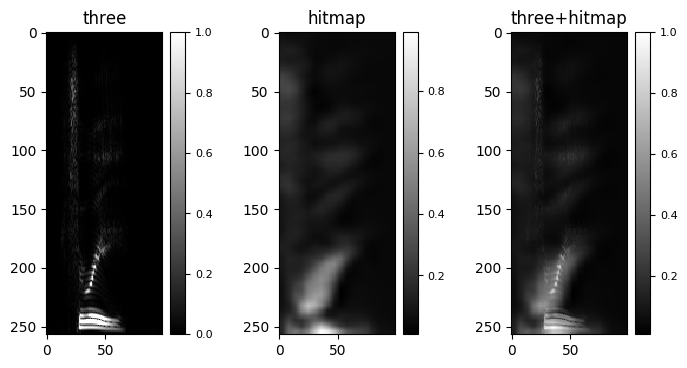

In [206]:
plt.figure(figsize=(8, 4), dpi=100)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,3,1)
plt.title('three')
plt.imshow(np.rot90(three_male_show), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 

plt.subplot(1,3,2)
plt.title('hitmap')
plt.imshow(np.rot90(cam), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 

plt.subplot(1,3,3)
plt.title('three+hitmap')
new_img = three_male_show+2*cam
new_img /= new_img.max()
plt.imshow(np.rot90(new_img), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 

In [207]:
## create a new session 
## and restore the model
with tf.Session(graph=g) as sess:
    load(saver, sess, epoch=100, path=model_path)

    conv1_weights = sess.run('conv_1/_weights/read:0')
    conv2_weights = sess.run('conv_2/_weights/read:0')
    conv3_weights = sess.run('conv_3/_weights/read:0')

    feed = {'tf_x:0': np.expand_dims(tree_male_input, axis=0),
            'fc_keep_prob:0':1.0}
    conv1_result = sess.run('conv_1/Conv2D:0', feed_dict=feed)
    conv2_result = sess.run('conv_2/Conv2D:0', feed_dict=feed)
    conv3_result = sess.run('conv_3/Conv2D:0', feed_dict=feed)
    
    conv1_active_result = sess.run('conv_1/activation:0', feed_dict=feed)
    conv2_active_result = sess.run('conv_2/activation:0', feed_dict=feed)
    conv3_active_result = sess.run('conv_3/activation:0', feed_dict=feed)
    
    
    print("Setting gradients to 1 for target class and rest to 0")
    # Conv layer tensor [?,7,7,512]
    conv_layer = tf.get_default_graph().get_tensor_by_name('conv_3/Conv2D:0')
    # [1000]-D tensor with target class index set to 1 and rest as 0
    predicted_class = y_dict['tree']
    nb_classes = 16
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    last_fc_layer = tf.get_default_graph().get_tensor_by_name('output_layer/net_pre-activation:0')
    signal = tf.multiply(last_fc_layer, one_hot)
    loss = tf.reduce_mean(signal)

    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict=feed)
    output = output[0]           # [7,7,512]
    grads_val = grads_val[0]     # [7,7,512]

    weights = np.mean(grads_val, axis = (0, 1))             # [512]
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)    # [7,7]

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (257,99), interpolation=cv2.INTER_LINEAR)

#     # Converting grayscale to 3-D
#     cam3 = np.expand_dims(cam, axis=2)
#     cam3 = np.tile(cam3,[1,1,3])

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0


In [208]:
original_image = tree_male
# tree_male_show = np.expand_dims(original_image, axis=2)
# tree_male_show = np.tile(tree_male_show,[1,1,3])
tree_male_show = original_image / np.max(original_image)
# tree_male_show.shape

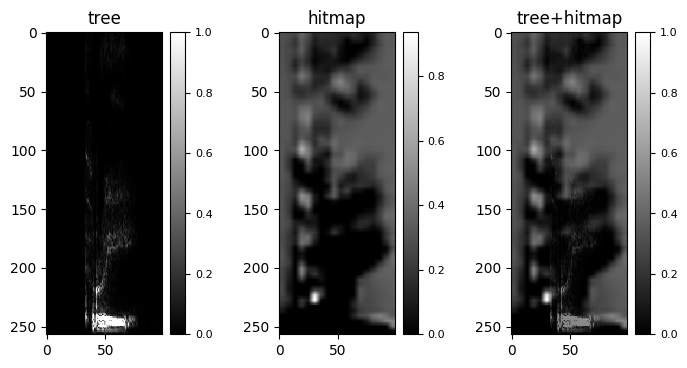

In [209]:
plt.figure(figsize=(8, 4), dpi=100)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,3,1)
plt.title('tree')
plt.imshow(np.rot90(tree_male_show), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)

plt.subplot(1,3,2)
plt.title('hitmap')
plt.imshow(np.rot90(cam), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)

plt.subplot(1,3,3)
plt.title('tree+hitmap')
new_img = tree_male_show+2*cam
new_img /= new_img.max()
plt.imshow(np.rot90(new_img), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Setting gradients to 1 for target class and rest to 0
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc

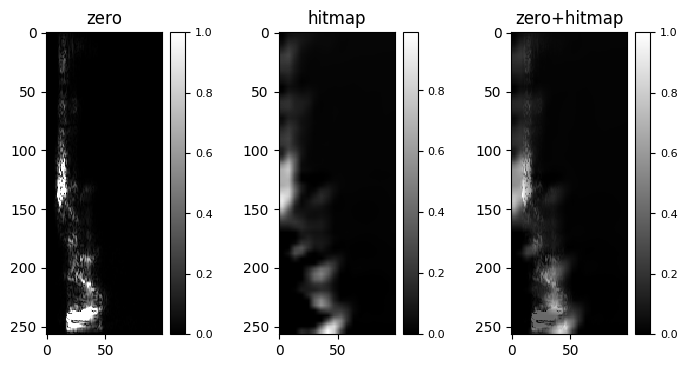

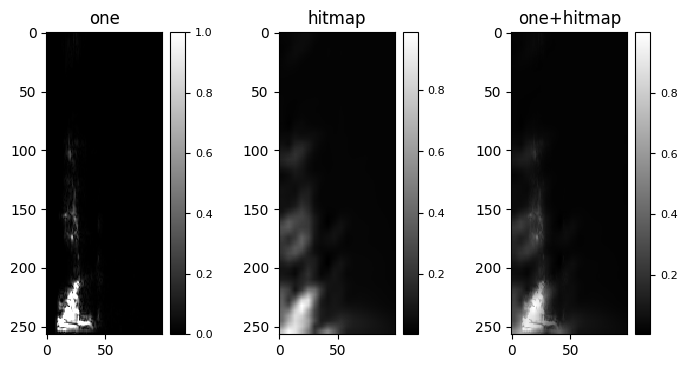

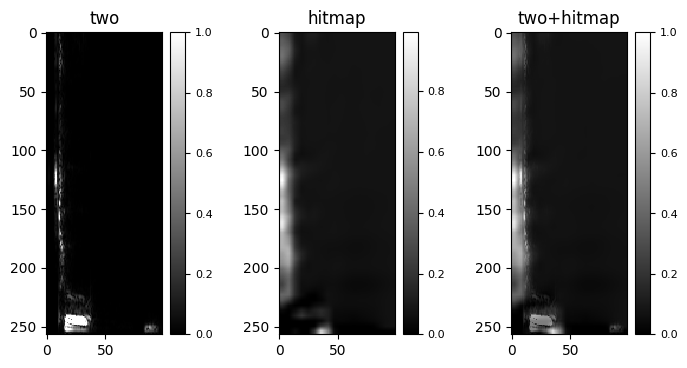

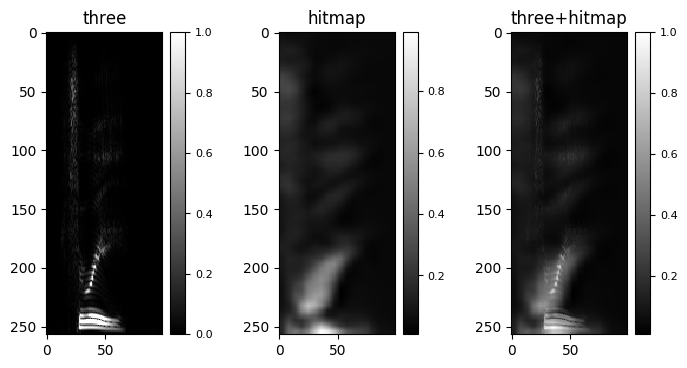

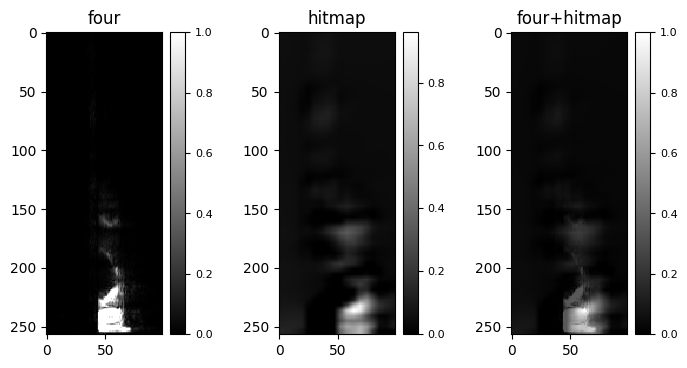

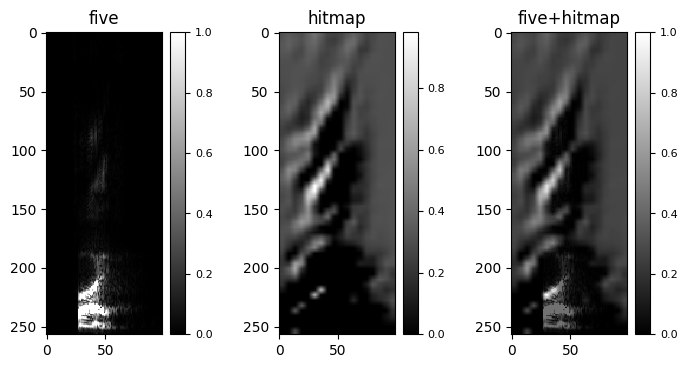

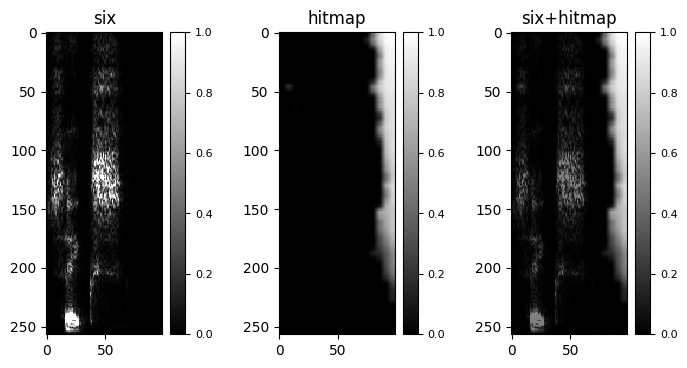

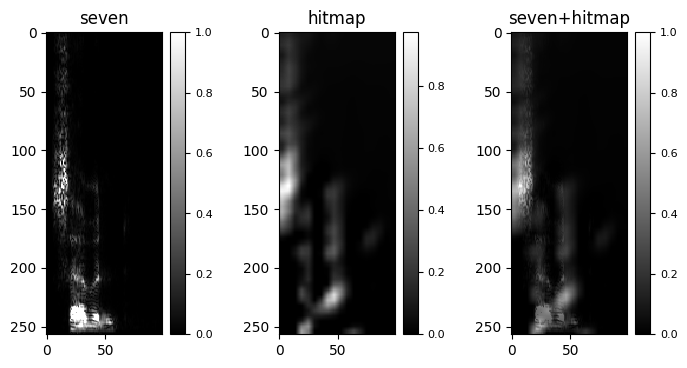

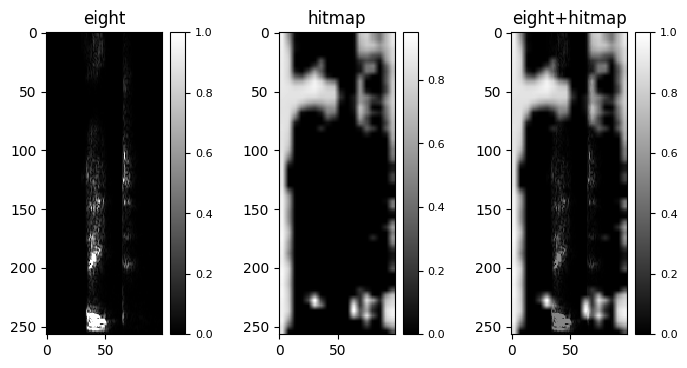

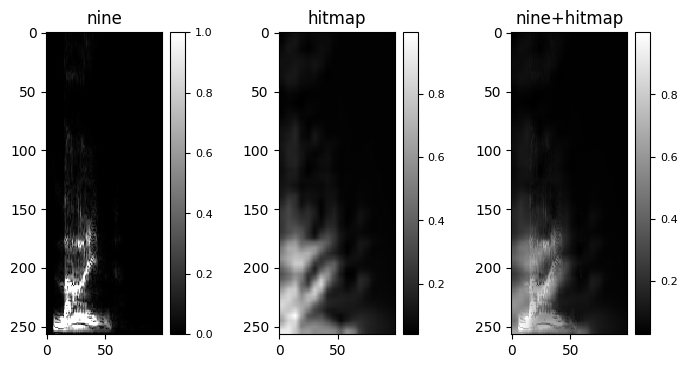

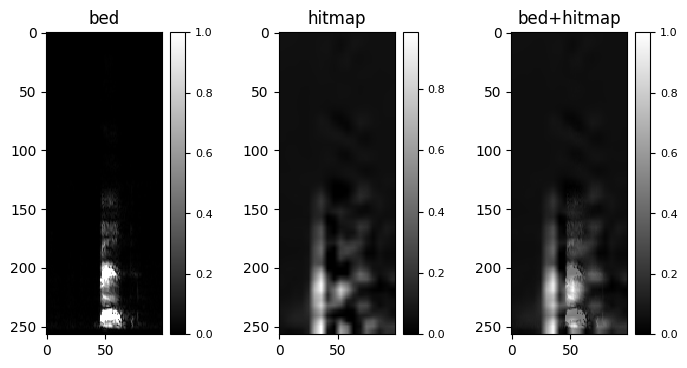

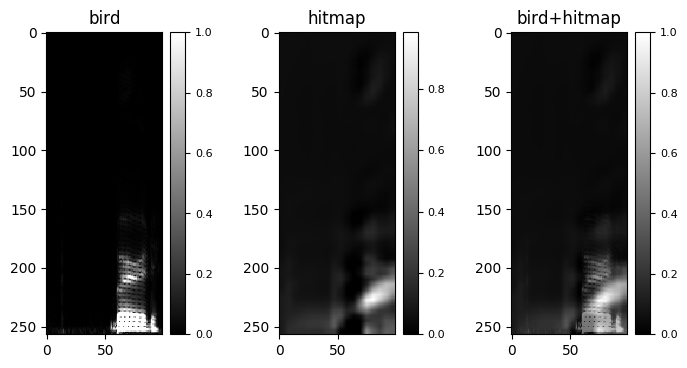

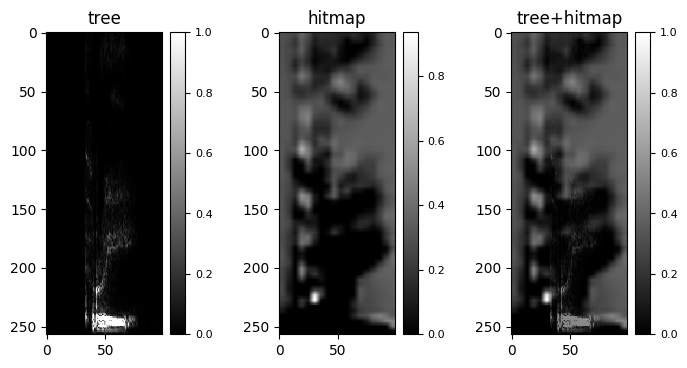

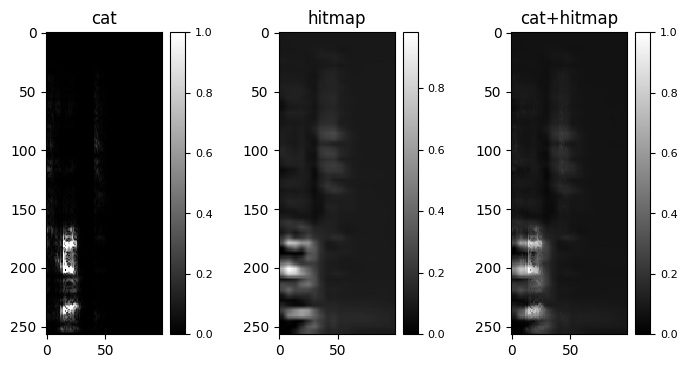

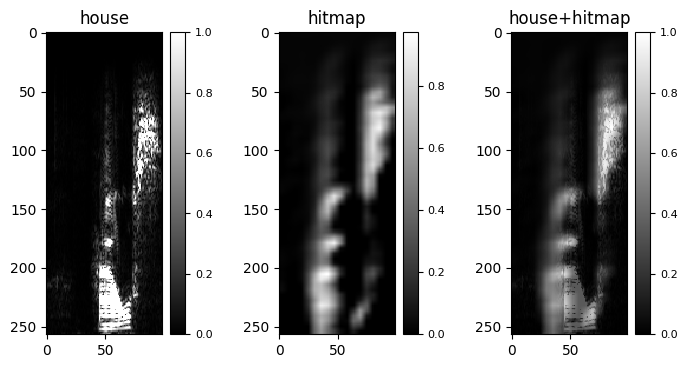

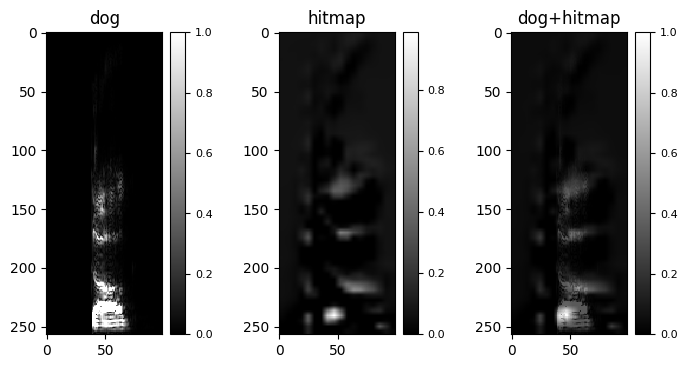

In [222]:
for target_string in list(y_dict.keys()):
    sound_male = cv2.imread(root_path+'sample/'+target_string+'_male.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
    sound_male_flatten = sound_male.flatten()
    sound_male_input = (sound_male_flatten - mean_vals) / std_val

    ## create a new session 
    ## and restore the model
    with tf.Session(graph=g) as sess:
        load(saver, sess, epoch=100, path=model_path)

        conv1_weights = sess.run('conv_1/_weights/read:0')
        conv2_weights = sess.run('conv_2/_weights/read:0')
        conv3_weights = sess.run('conv_3/_weights/read:0')

        feed = {'tf_x:0': np.expand_dims(sound_male_input, axis=0),
                'fc_keep_prob:0':1.0}
        conv1_result = sess.run('conv_1/Conv2D:0', feed_dict=feed)
        conv2_result = sess.run('conv_2/Conv2D:0', feed_dict=feed)
        conv3_result = sess.run('conv_3/Conv2D:0', feed_dict=feed)

        conv1_active_result = sess.run('conv_1/activation:0', feed_dict=feed)
        conv2_active_result = sess.run('conv_2/activation:0', feed_dict=feed)
        conv3_active_result = sess.run('conv_3/activation:0', feed_dict=feed)


        print("Setting gradients to 1 for target class and rest to 0")
        # Conv layer tensor [?,7,7,512]
        conv_layer = tf.get_default_graph().get_tensor_by_name('conv_3/Conv2D:0')
        # [1000]-D tensor with target class index set to 1 and rest as 0
        predicted_class = y_dict[target_string]
        nb_classes = 16
        one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
        last_fc_layer = tf.get_default_graph().get_tensor_by_name('output_layer/net_pre-activation:0')
        signal = tf.multiply(last_fc_layer, one_hot)
        loss = tf.reduce_mean(signal)

        grads = tf.gradients(loss, conv_layer)[0]
        # Normalizing the gradients
        norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

        output, grads_val = sess.run([conv_layer, norm_grads], feed_dict=feed)
        output = output[0]           # [7,7,512]
        grads_val = grads_val[0]     # [7,7,512]

        weights = np.mean(grads_val, axis = (0, 1))             # [512]
        cam = np.ones(output.shape[0 : 2], dtype = np.float32)    # [7,7]

        # Taking a weighted average
        for i, w in enumerate(weights):
            cam += w * output[:, :, i]

        # Passing through ReLU
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = cv2.resize(cam, (257,99), interpolation=cv2.INTER_LINEAR)

        # Converting grayscale to 3-D
    #     cam3 = np.expand_dims(cam, axis=2)
    #     cam3 = np.tile(cam3,[1,1,3])

    original_image = sound_male
    # three_male_show = np.expand_dims(original_image, axis=2)
    # three_male_show = np.tile(three_male_show,[1,1,3])
    image_male_show = original_image / np.max(original_image)
    # three_male_show.shape

    fig = plt.figure(figsize=(8, 4), dpi=100)
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(1,3,1)
    plt.title(target_string)
    plt.imshow(np.rot90(image_male_show), cmap='gray')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

    plt.subplot(1,3,2)
    plt.title('hitmap')
    plt.imshow(np.rot90(cam), cmap='gray')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

    plt.subplot(1,3,3)
    plt.title(target_string+'+hitmap')
    new_img = image_male_show+2*cam
    new_img /= new_img.max()
    plt.imshow(np.rot90(new_img), cmap='gray')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

    fig.savefig('visualization/attention_map/'+target_string+'.png', transparent=True)

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100
Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100


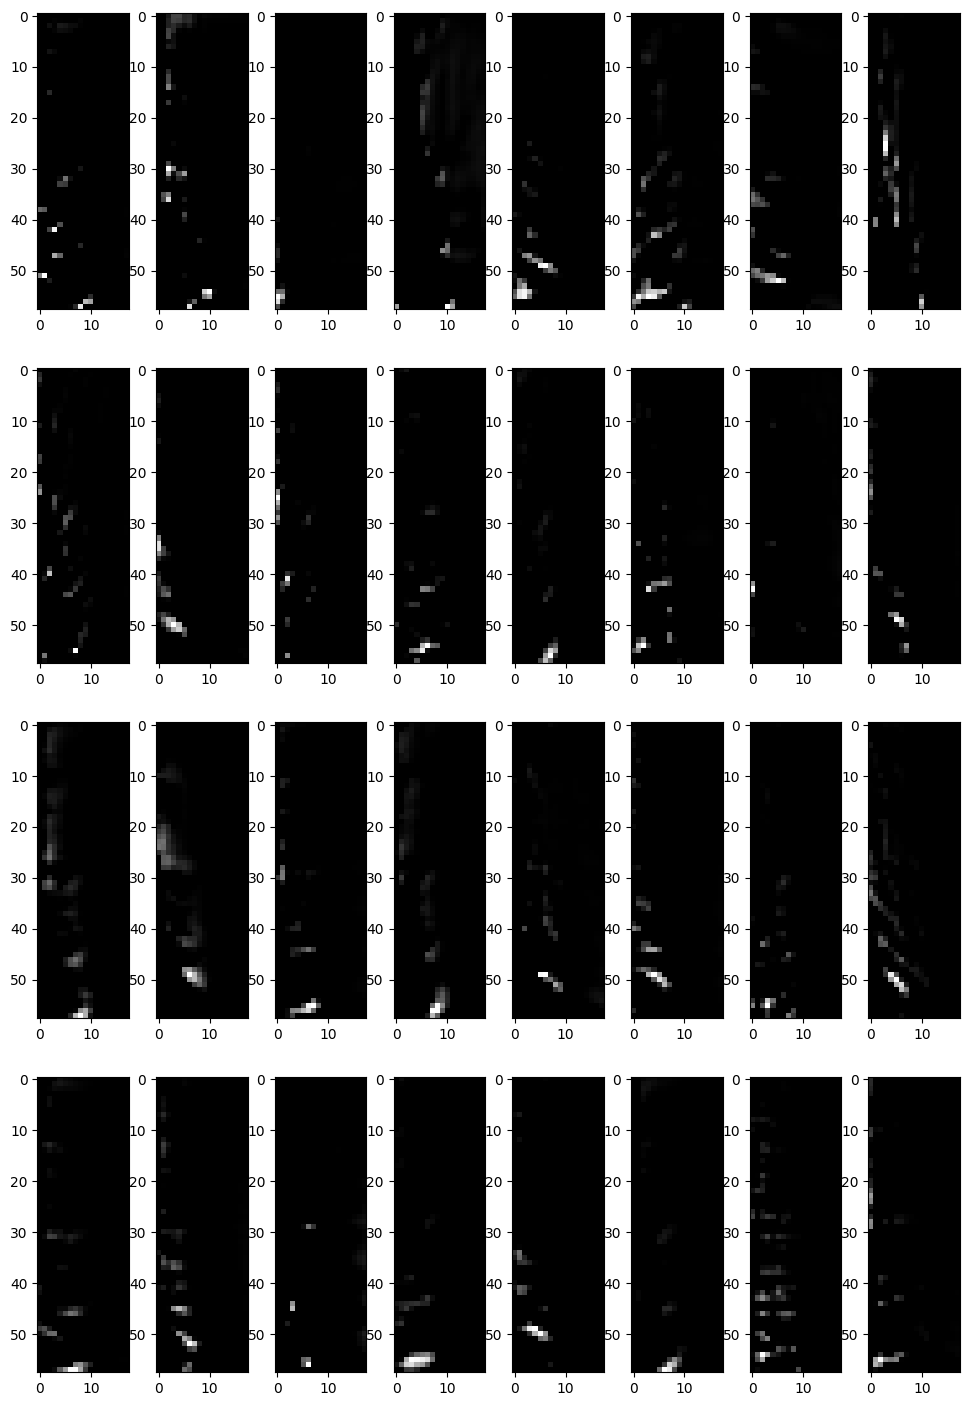

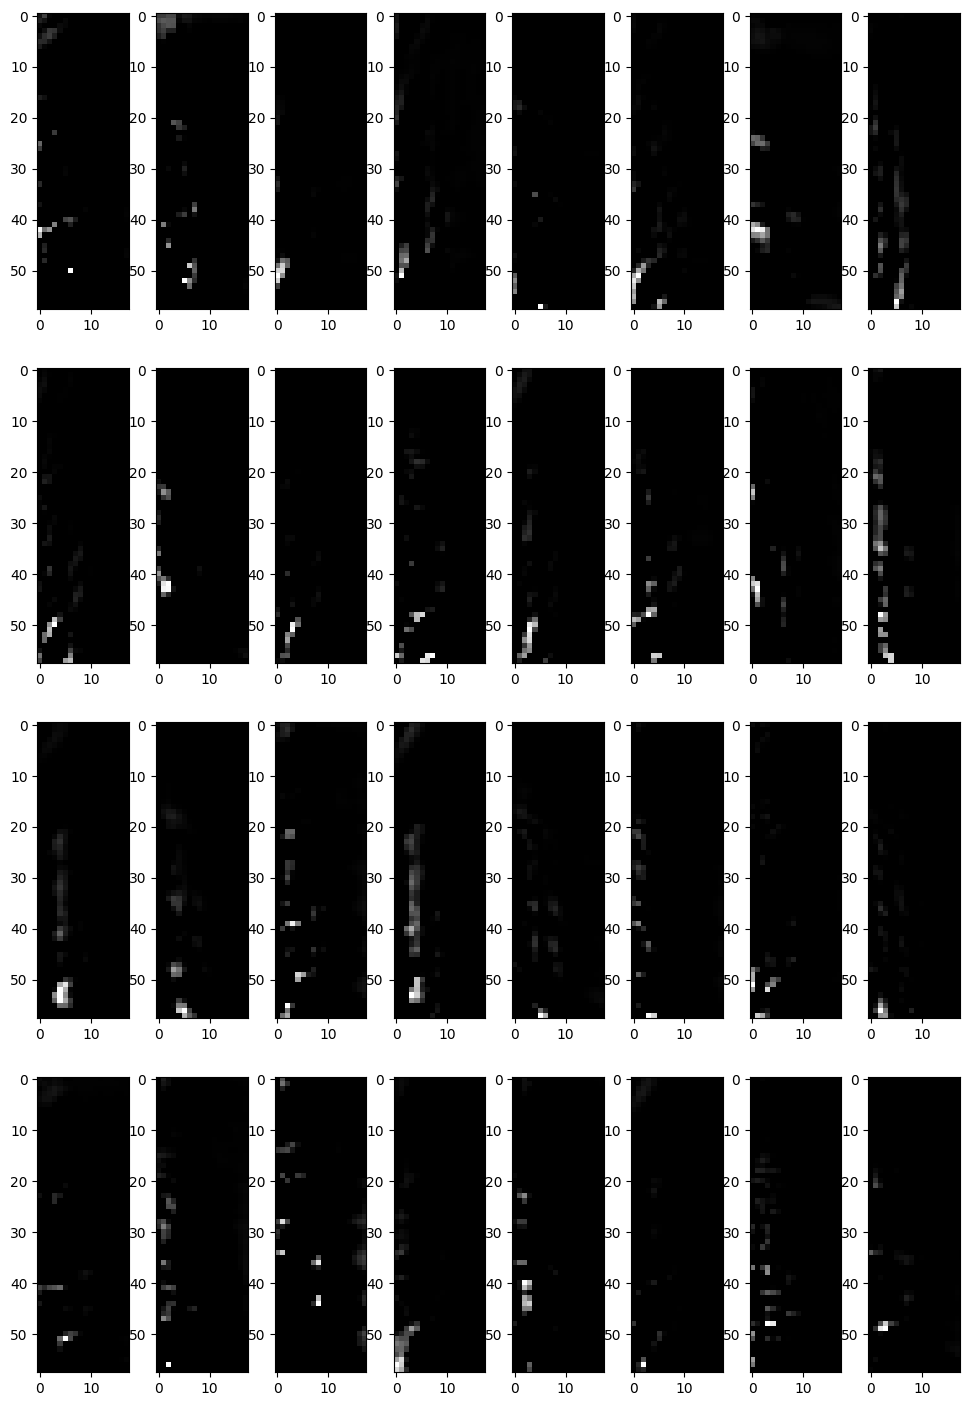

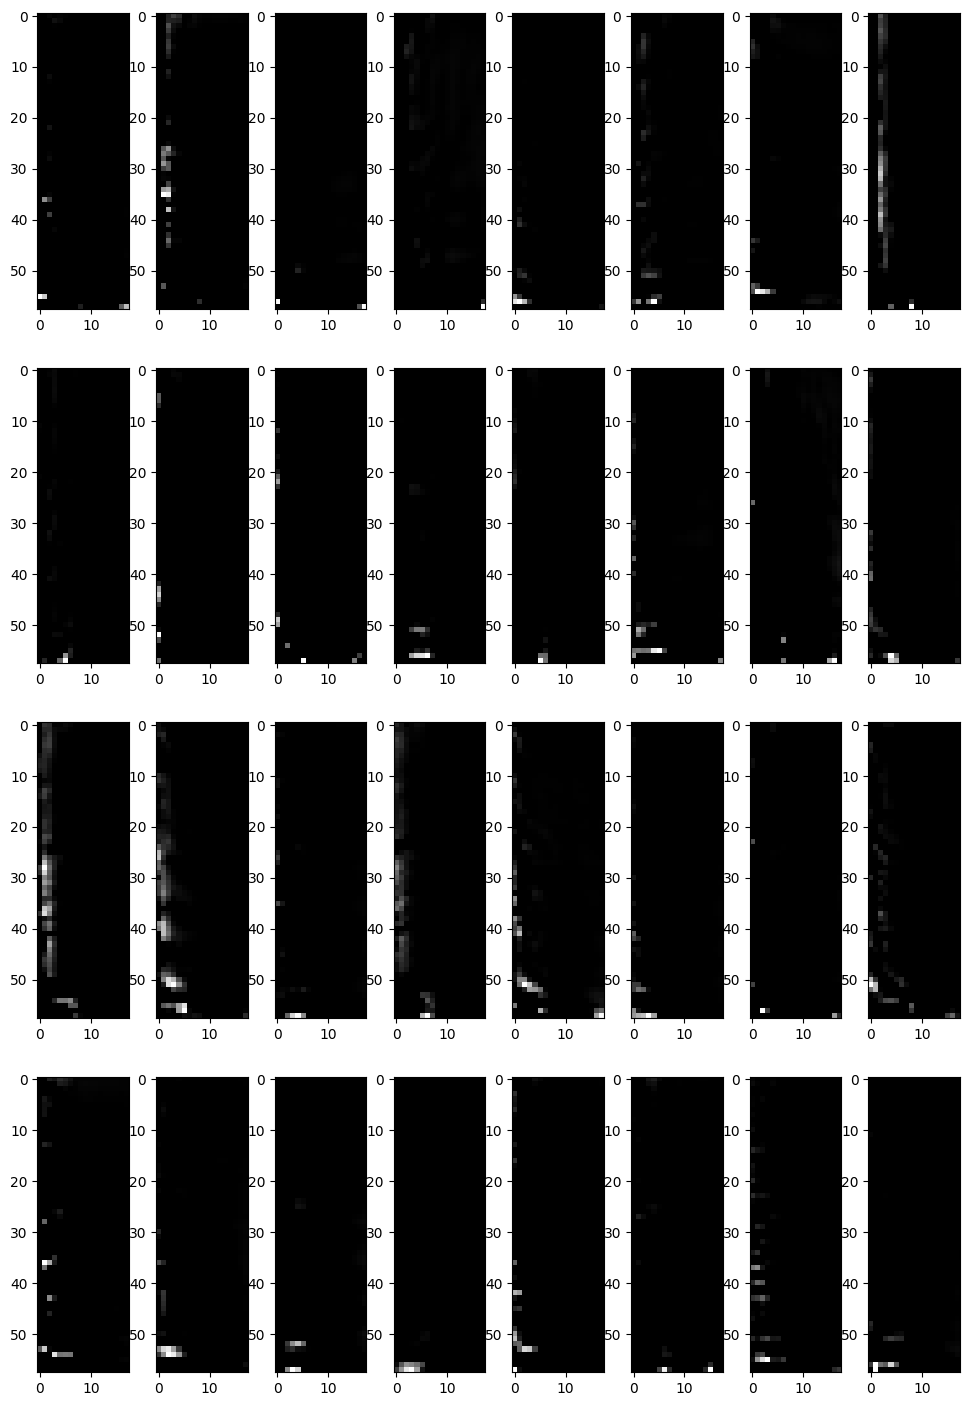

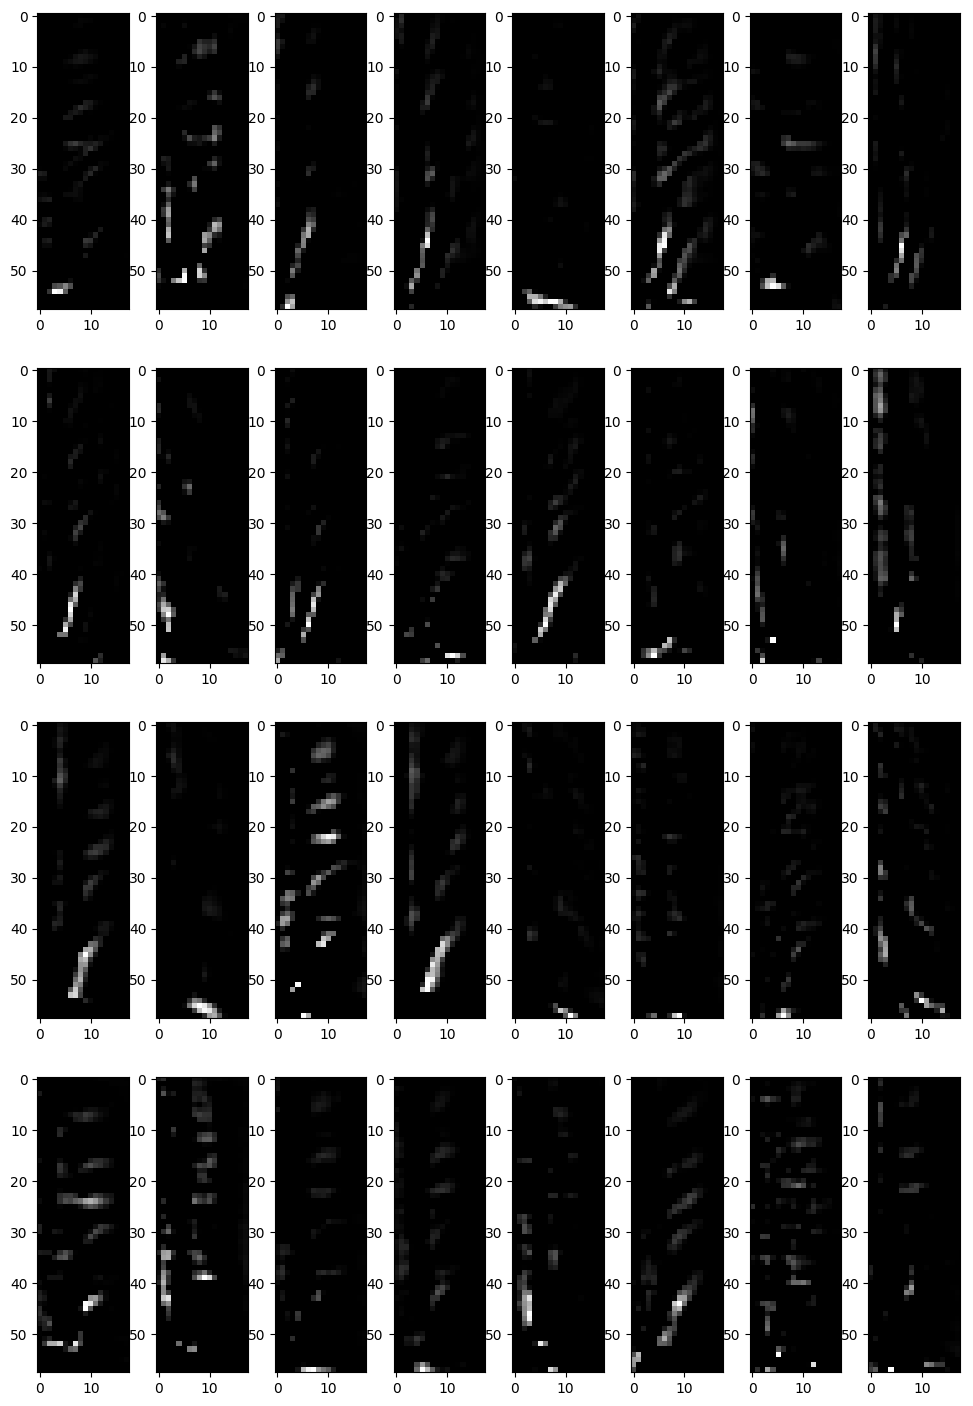

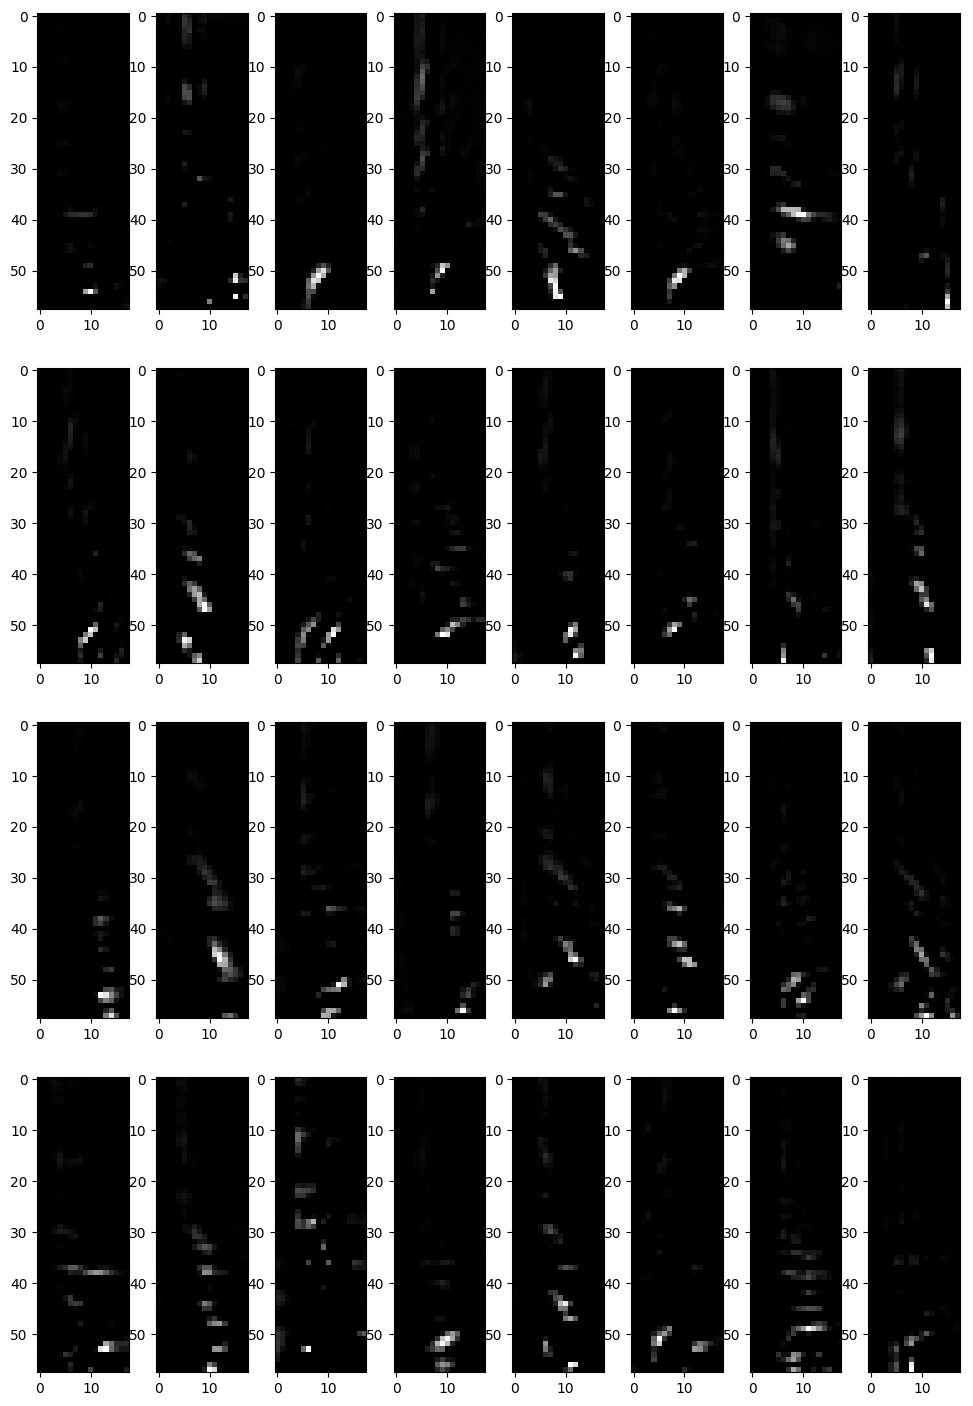

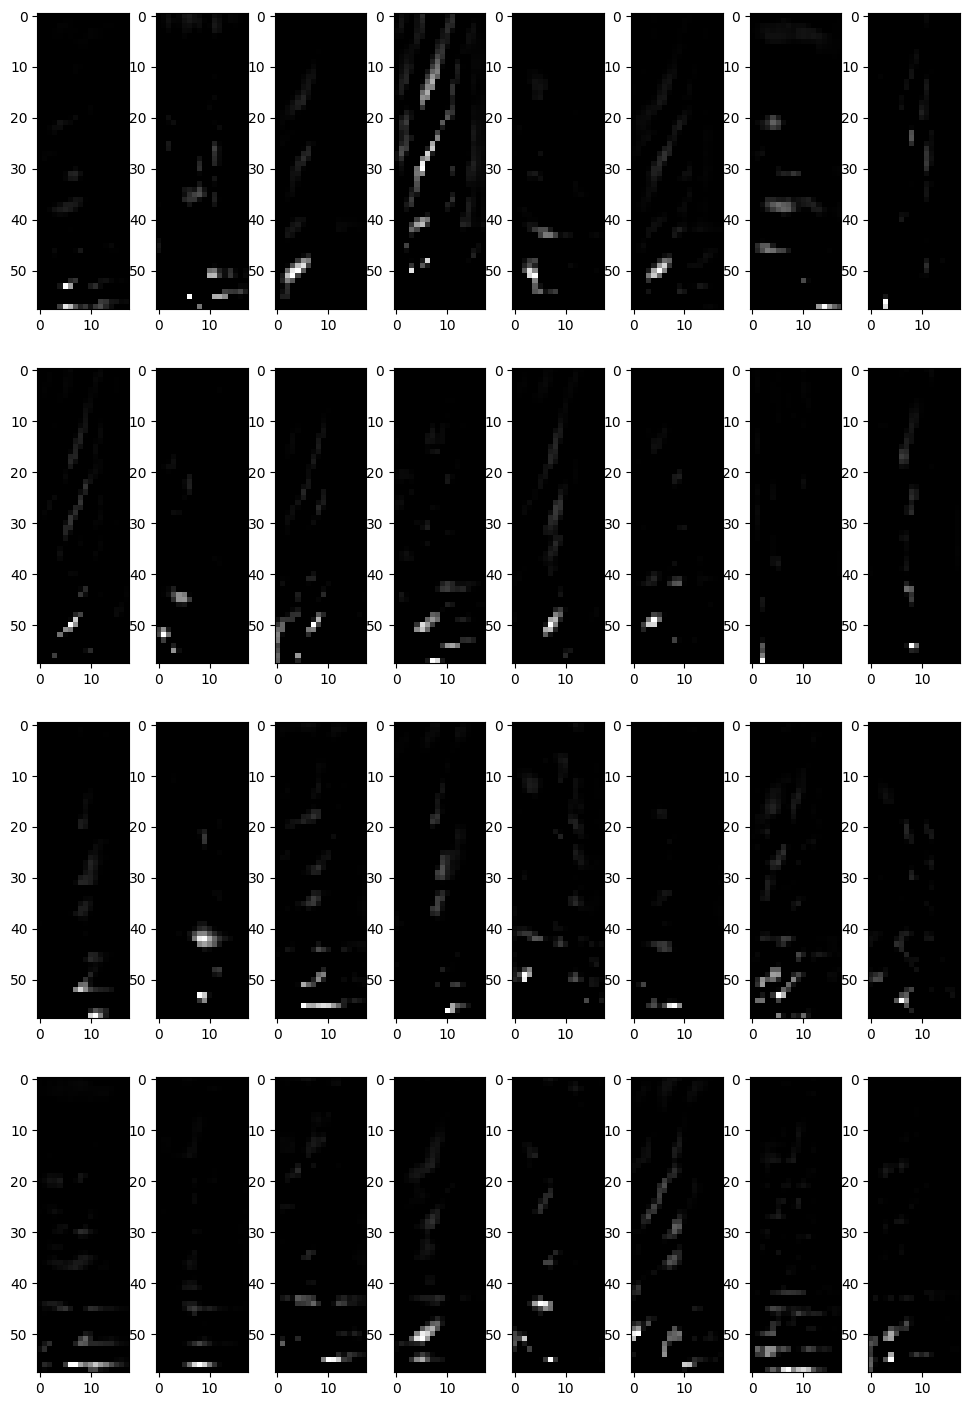

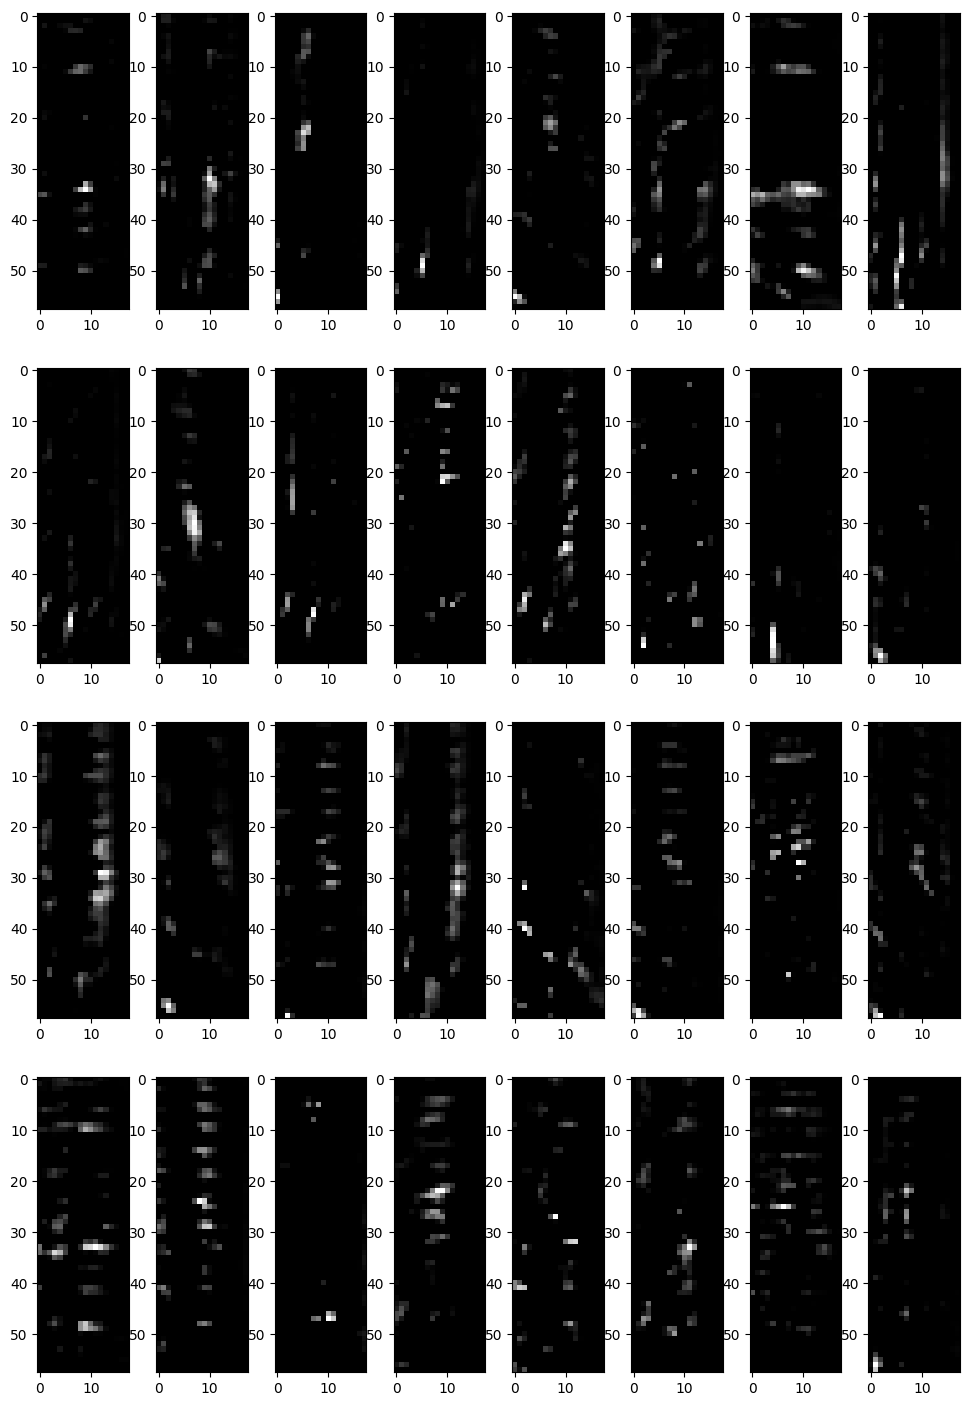

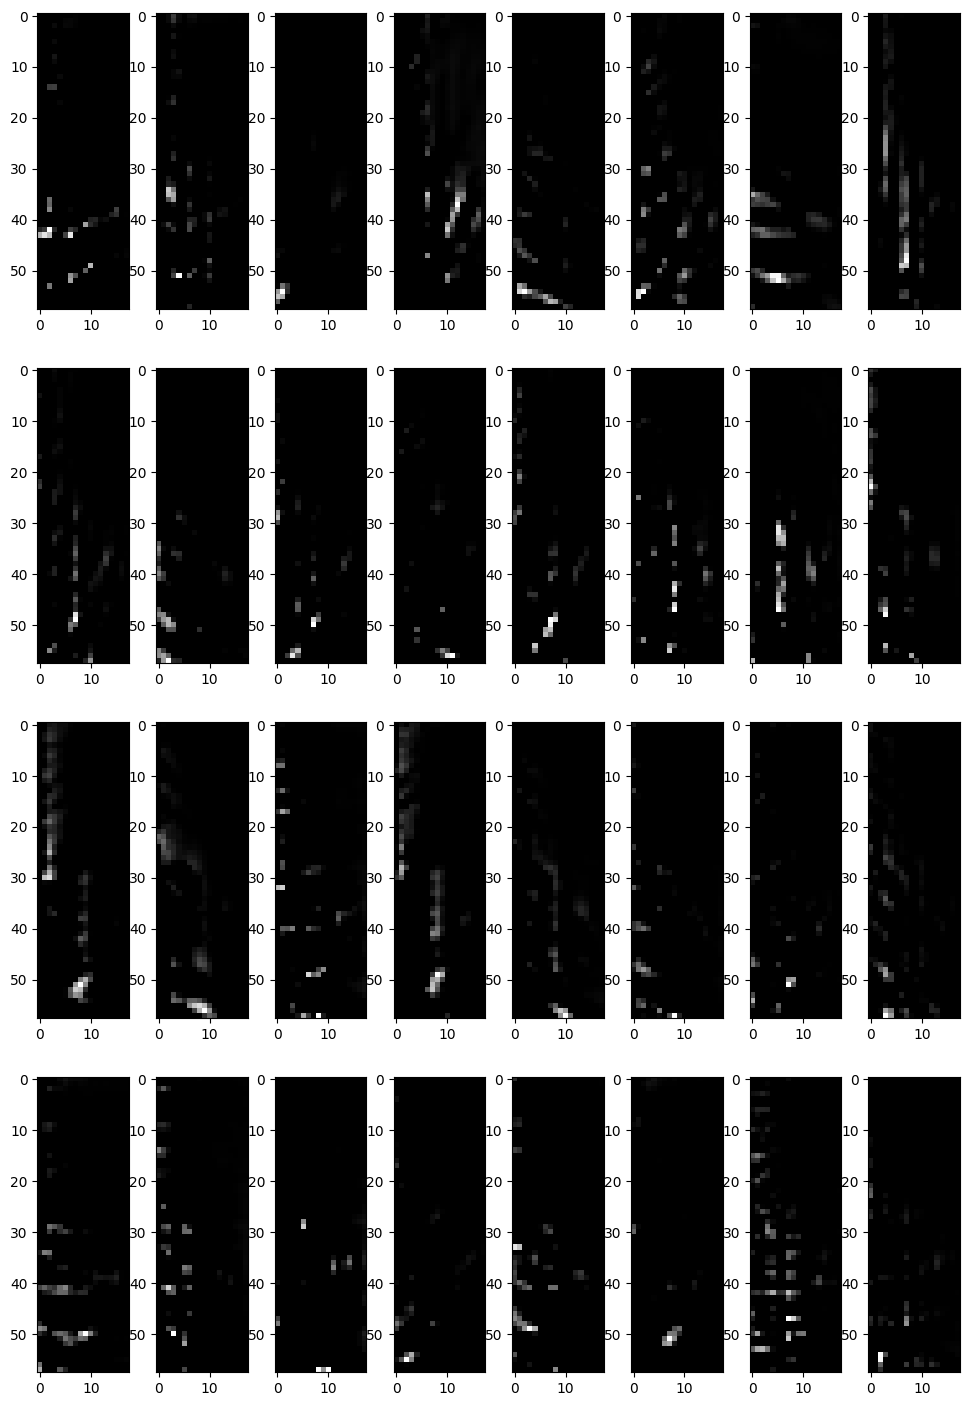

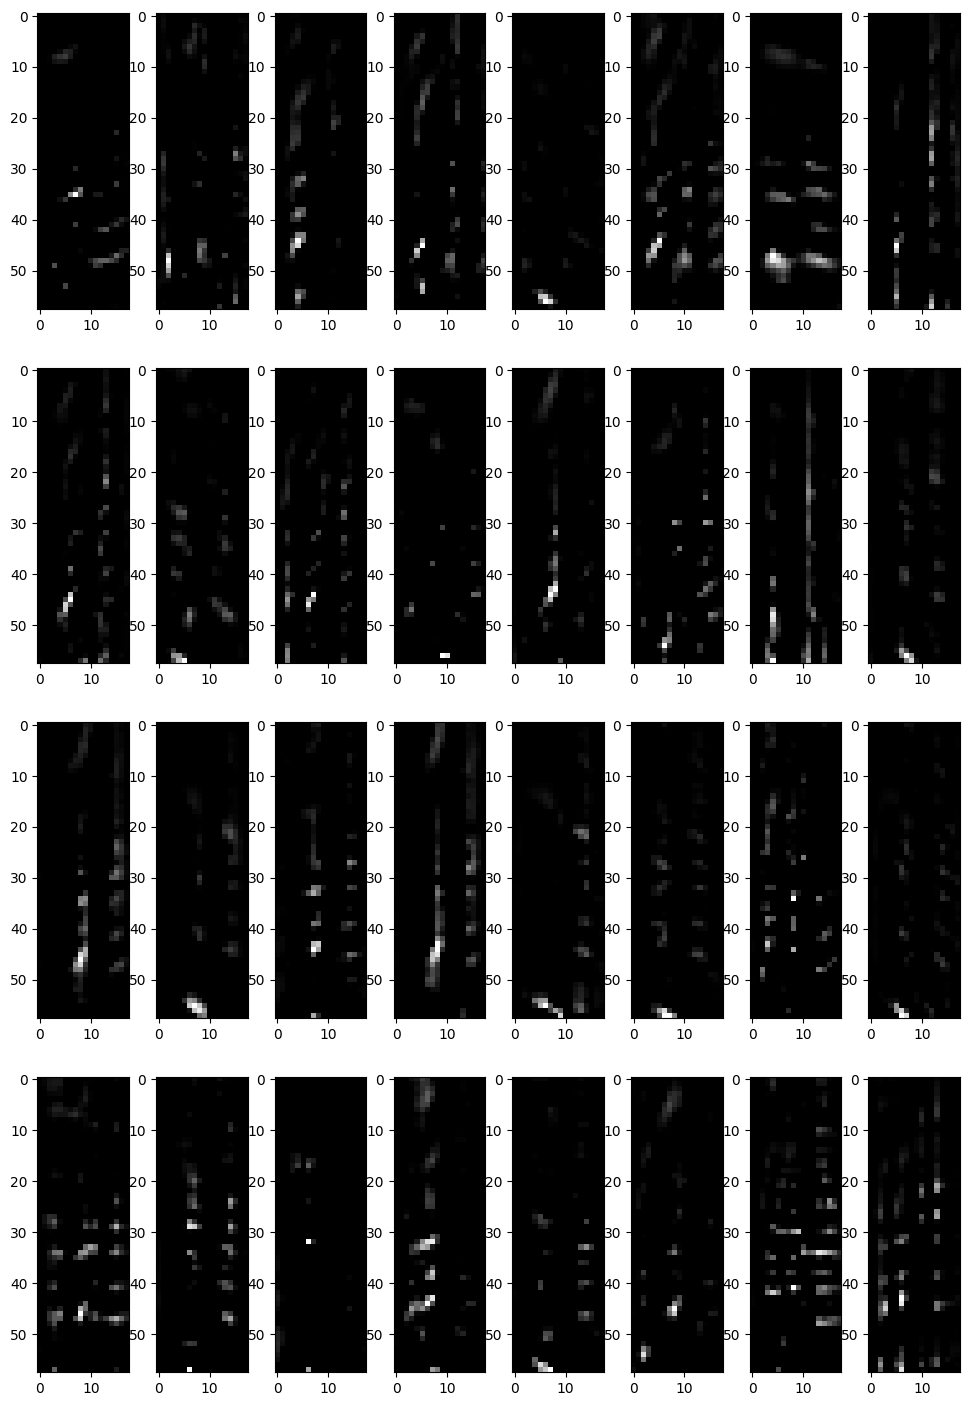

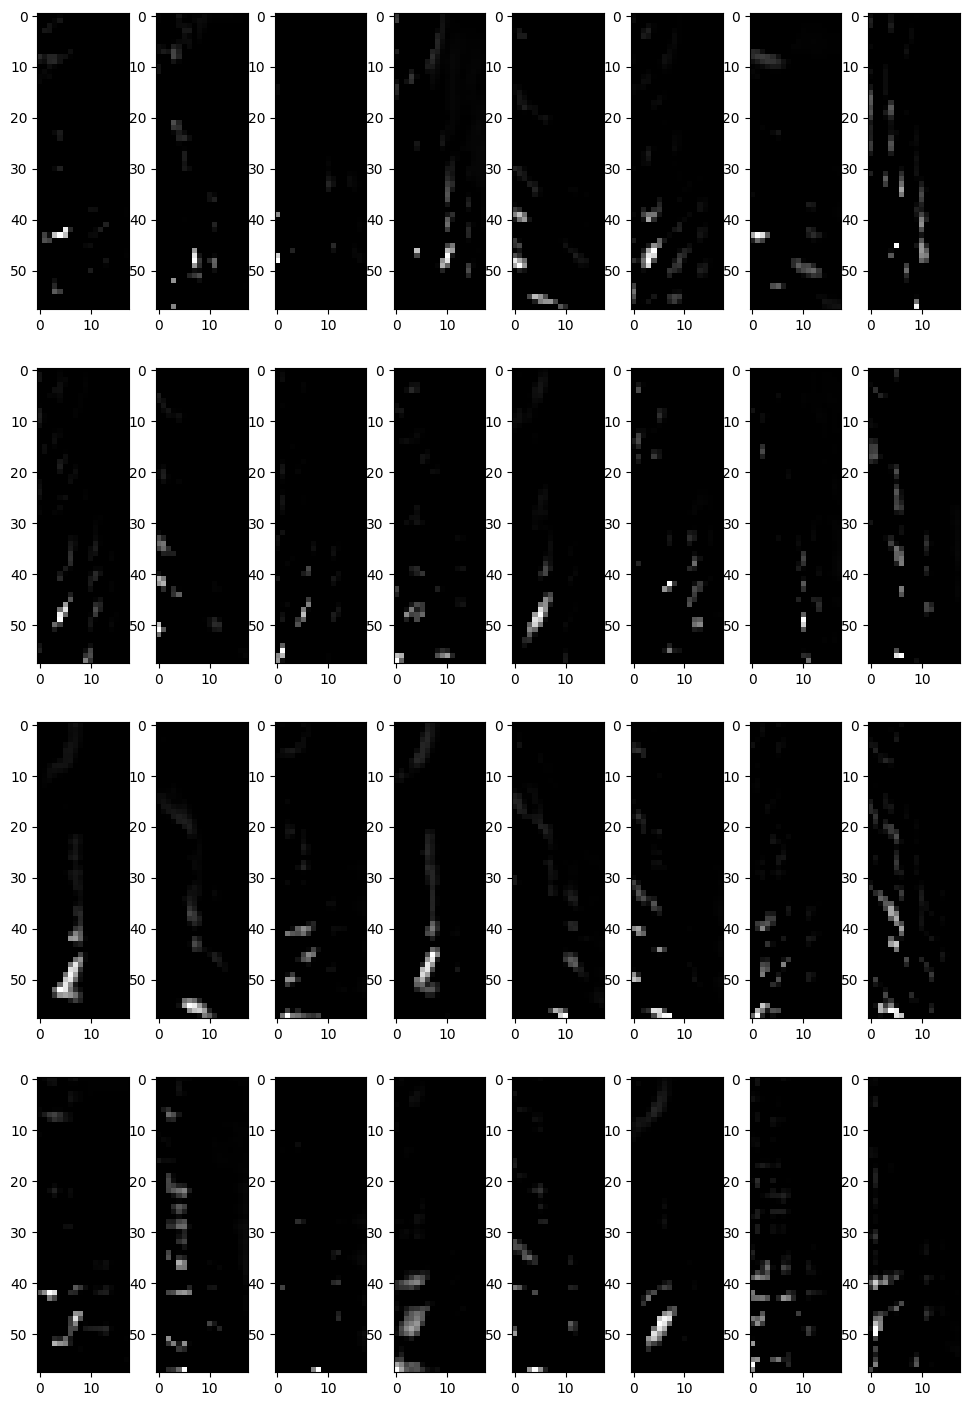

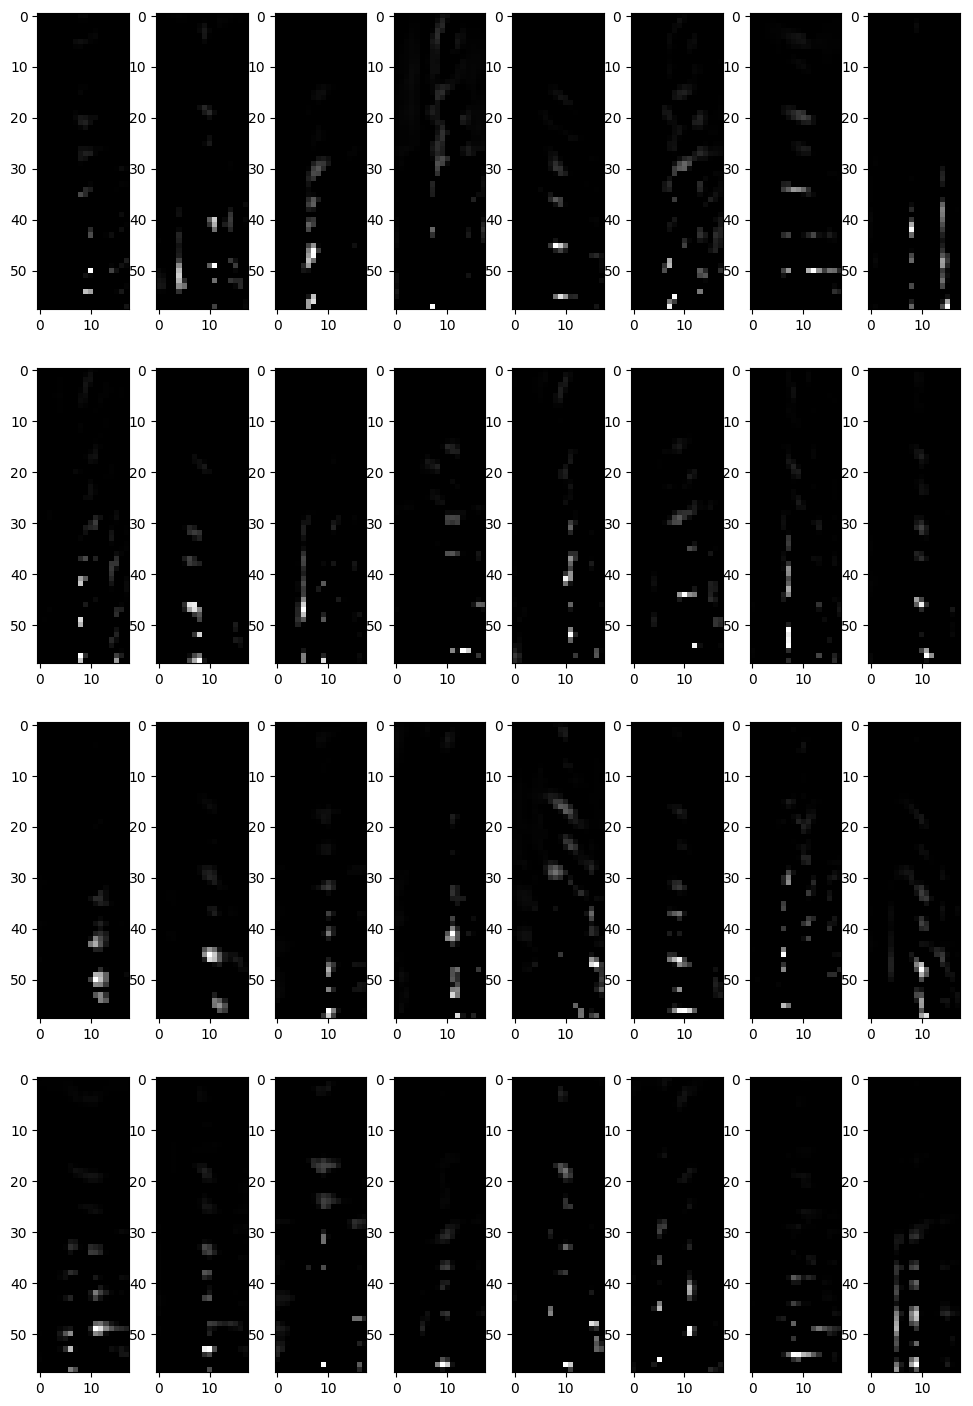

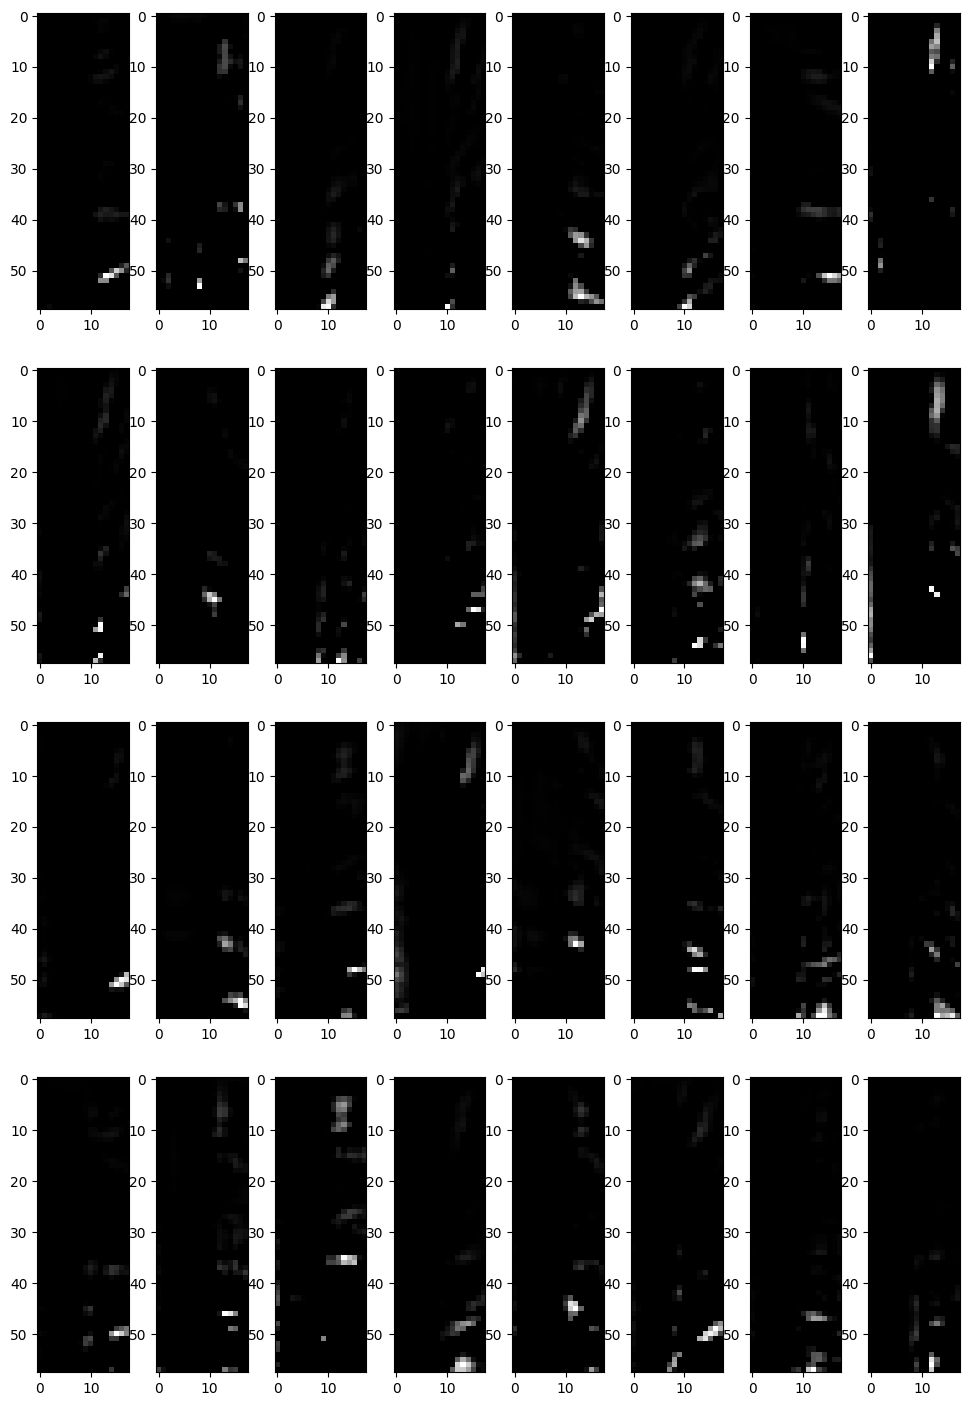

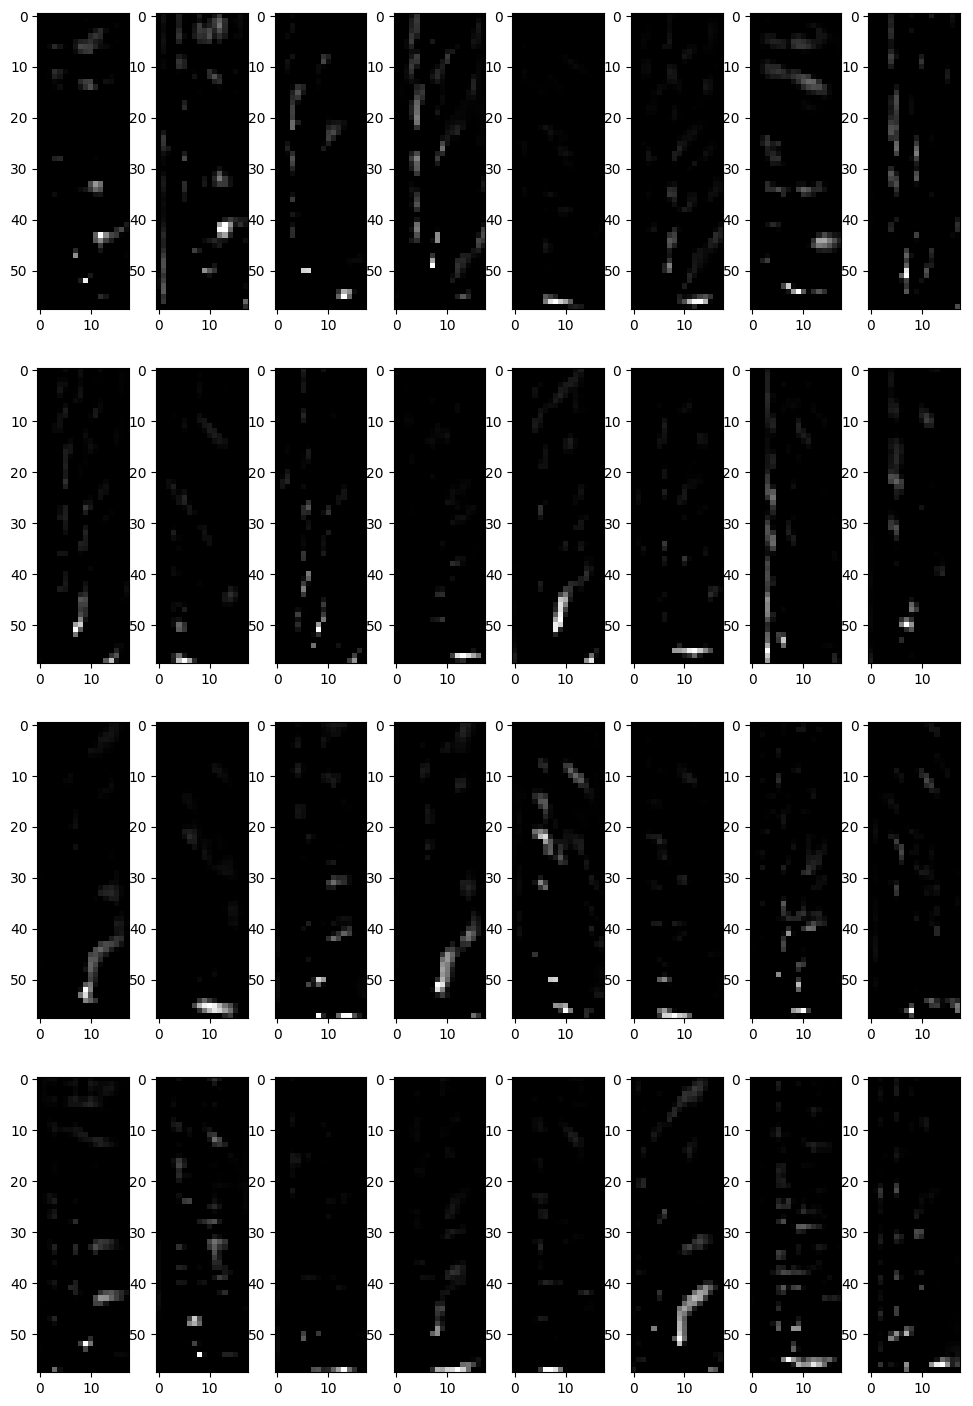

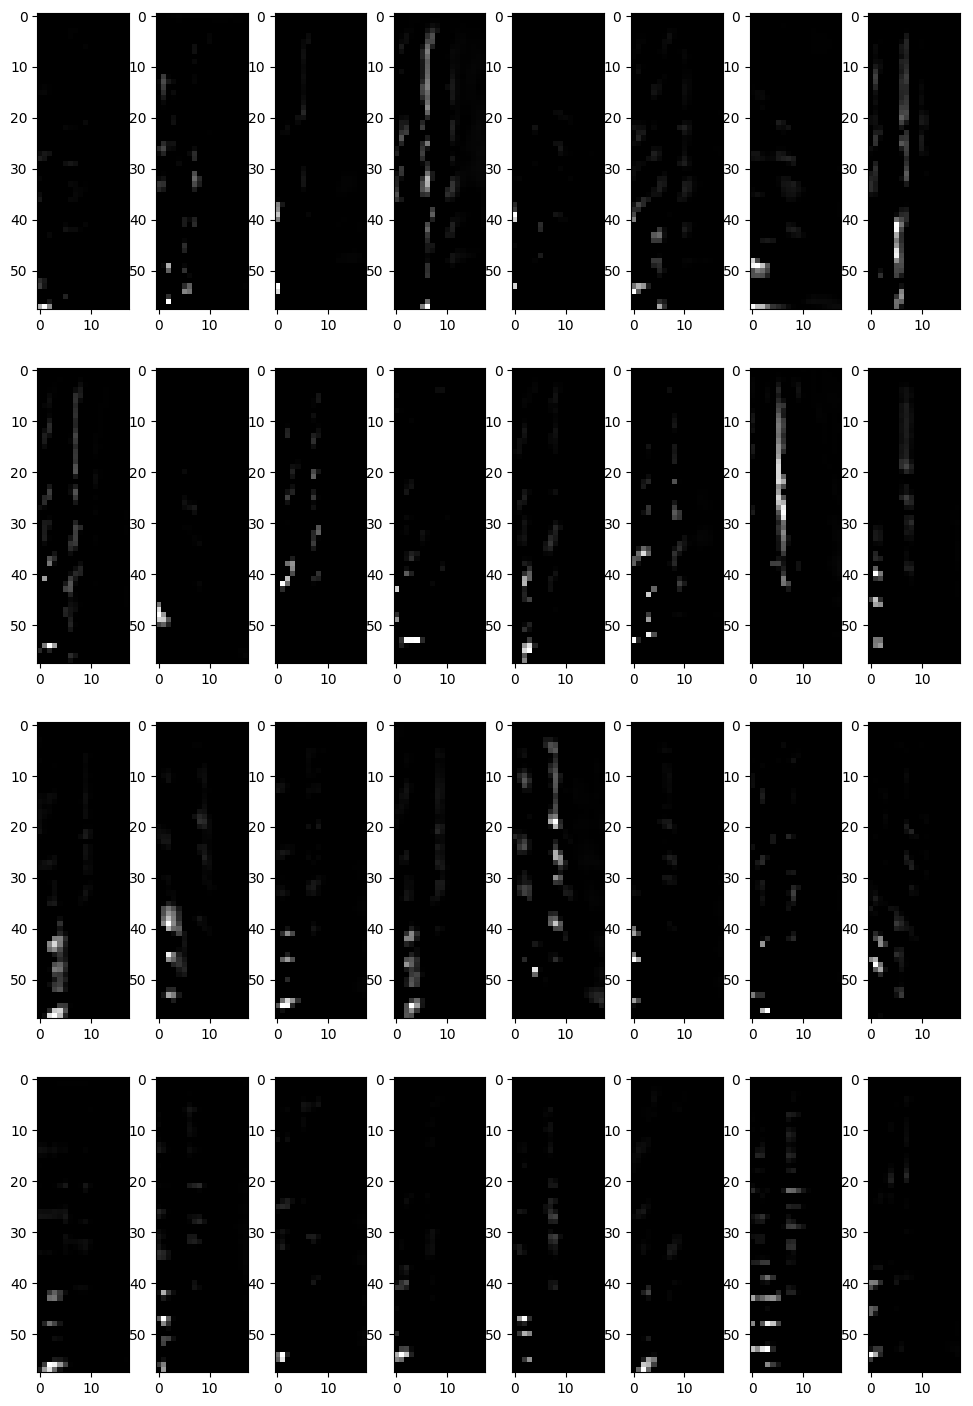

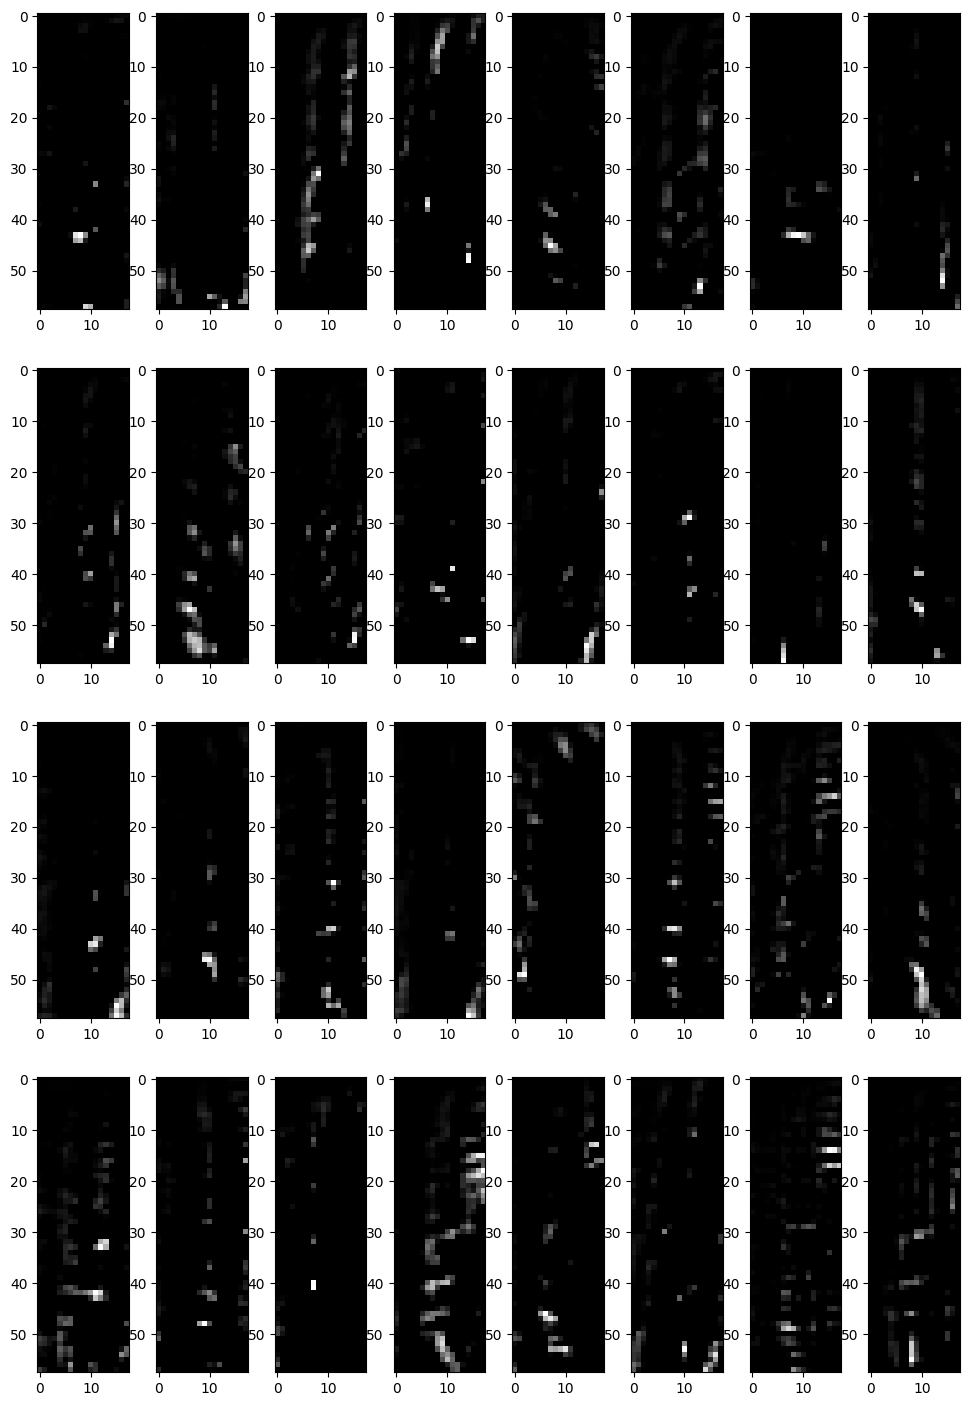

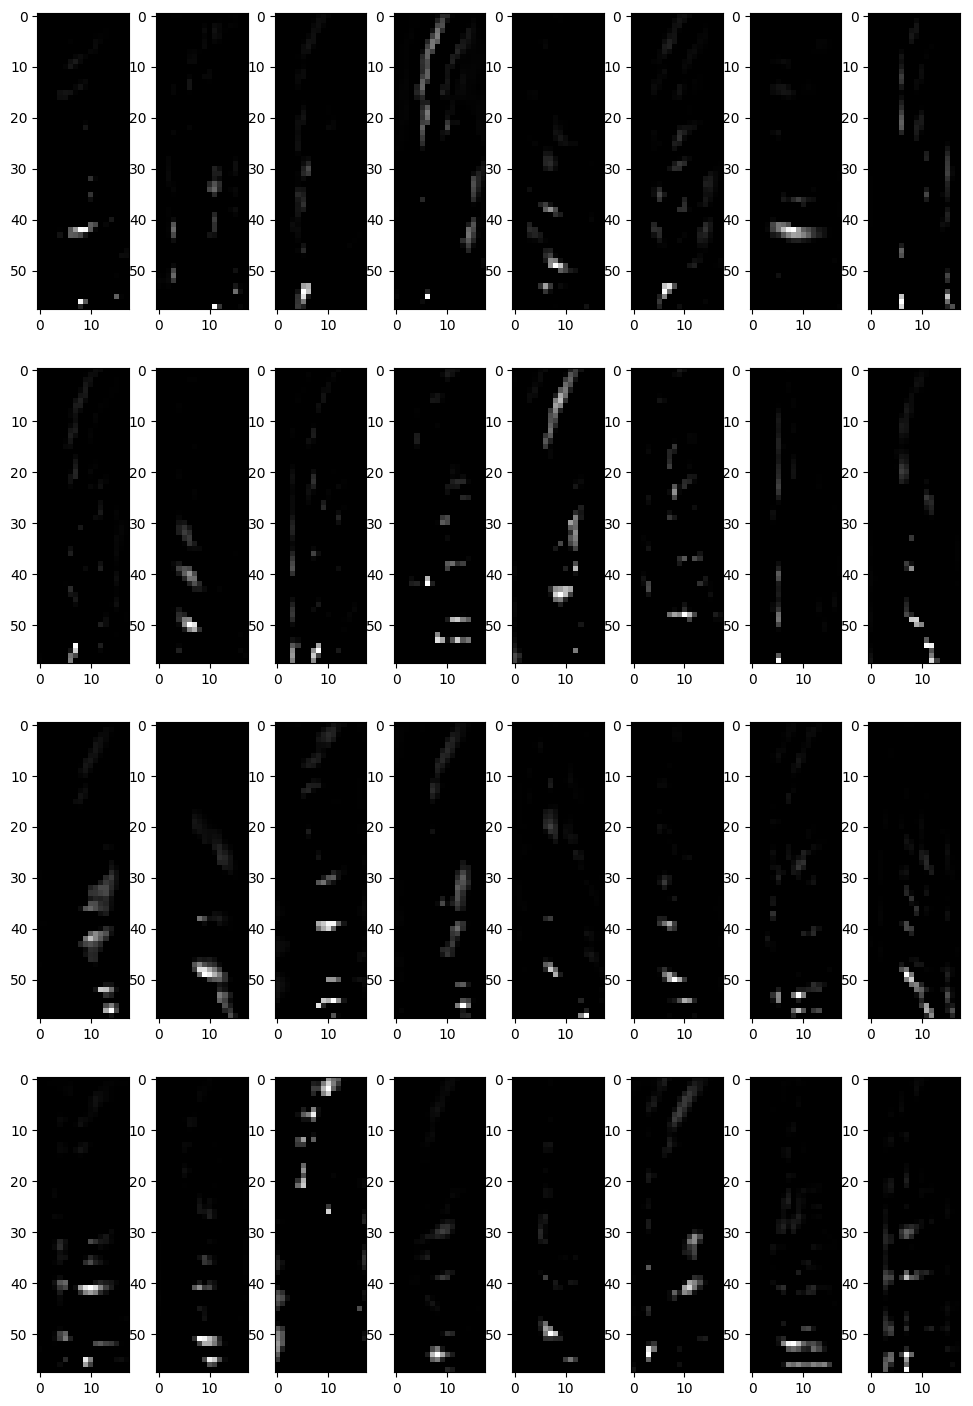

In [223]:
for target_string in list(y_dict.keys()):
    sound_male = cv2.imread(root_path+'sample/'+target_string+'_male.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
    sound_male_flatten = sound_male.flatten()
    sound_male_input = (sound_male_flatten - mean_vals) / std_val

    ## create a new session 
    ## and restore the model
    with tf.Session(graph=g) as sess:
        load(saver, sess, epoch=100, path=model_path)

#         conv1_weights = sess.run('conv_1/_weights/read:0')
#         conv2_weights = sess.run('conv_2/_weights/read:0')
#         conv3_weights = sess.run('conv_3/_weights/read:0')

        feed = {'tf_x:0': np.expand_dims(sound_male_input, axis=0), 
                'fc_keep_prob:0':1.0}
#         conv1_result = sess.run('conv_1/Conv2D:0', feed_dict=feed)
#         conv2_result = sess.run('conv_2/Conv2D:0', feed_dict=feed)
        conv3_result = sess.run('conv_3/Conv2D:0', feed_dict=feed)
        conv3_active_result = sess.run('conv_3/activation:0', feed_dict=feed)
        conv3_active_output = np.swapaxes(conv3_active_result[0], 0, 2)

    fig = plt.figure(figsize=(12, 18), dpi=100)
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(np.rot90(conv3_active_output[i].T), cmap='gray')

    os.makedirs('visualization/feature_map/', exist_ok=True)
    fig.savefig('visualization/feature_map/'+target_string+'.png', transparent=True)

In [93]:
with tf.Session(graph=g) as sess:
    load(saver, sess, epoch=100, path=model_path)
    
    fc1_val = sess.run('fc_1/_weights:0')
    fc2_val = sess.run('output_layer/_weights:0')

#     ## 1st FC layer: Fully Connected
#     print('\nBuilding 1st FC layer:')
#     fc1 = fc_layer(conv3_pool, name='fc_1',
#                   n_output_units=1024,
#                   activation_fn=tf.nn.relu)

#     ## Dropout
#     keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
#     fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob,
#                             name='fc1_dropout_layer')

Loading model from ./model/cnn_3conv_1fc/
INFO:tensorflow:Restoring parameters from ./model/cnn_3conv_1fc/cnn-model.ckpt-100


In [225]:
conv1_output = np.swapaxes(conv1_result[0], 0, 2)
conv2_output = np.swapaxes(conv2_result[0], 0, 2)
conv3_output = np.swapaxes(conv3_result[0], 0, 2)

conv1_active_output = np.swapaxes(conv1_active_result[0], 0, 2)
conv2_active_output = np.swapaxes(conv2_active_result[0], 0, 2)
conv3_active_output = np.swapaxes(conv3_active_result[0], 0, 2)

original_image = tree_male
original_image_std = np.reshape(three_male_input, [99, 257])
# original_image_std = np.swapaxes(tree_male_input, 0, 1)

# sio.savemat('conv_info.mat', {'conv1_weights':weight_value,
#                               'conv1_input':original_image,
#                               'conv1_output':conv1_output
#                              })

ValueError: keyword cmap is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_contains', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms', 'grid_aa', 'grid_c', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

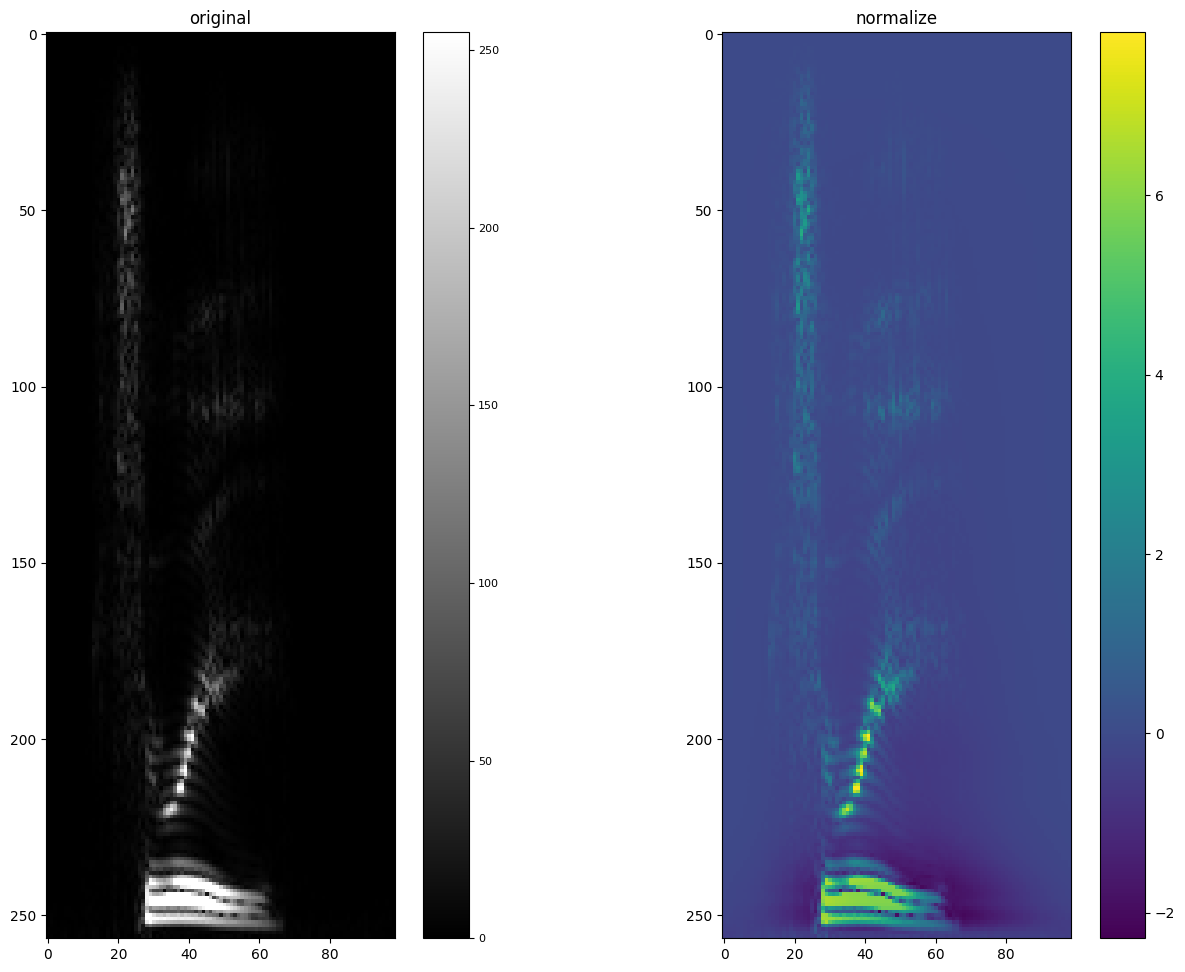

In [226]:
plt.figure(figsize=(16, 12), dpi=100)

plt.subplot(1,2,1)
plt.title('original')
plt.imshow(np.rot90(three_male), cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 

plt.subplot(1,2,2)
plt.title('normalize')
plt.imshow(np.rot90(original_image_std))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8, cmap='gray') 

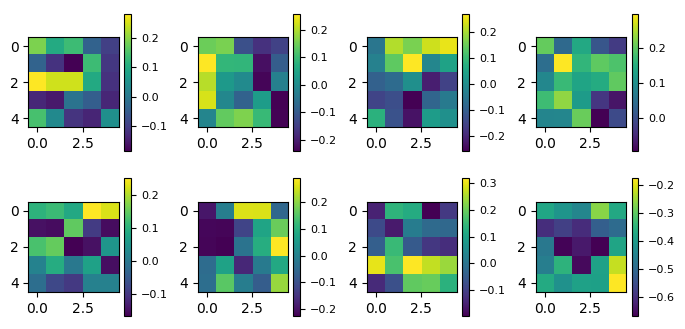

In [83]:
plt.figure(figsize=(8, 4), dpi=100)
plt.subplots_adjust(wspace=0.5)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.rot90(conv1_weights[:,:,0,i].T))
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

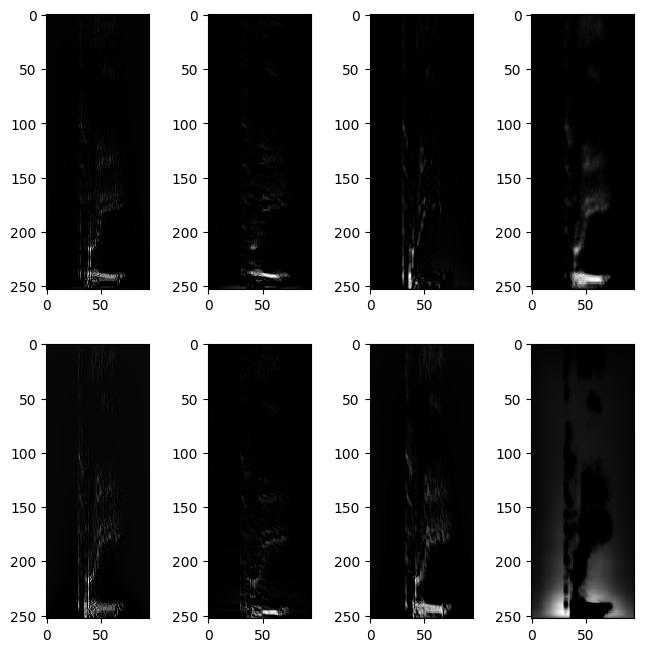

In [54]:
plt.figure(figsize=(8, 8), dpi=100)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.rot90(conv1_active_output[i].T), cmap='gray')

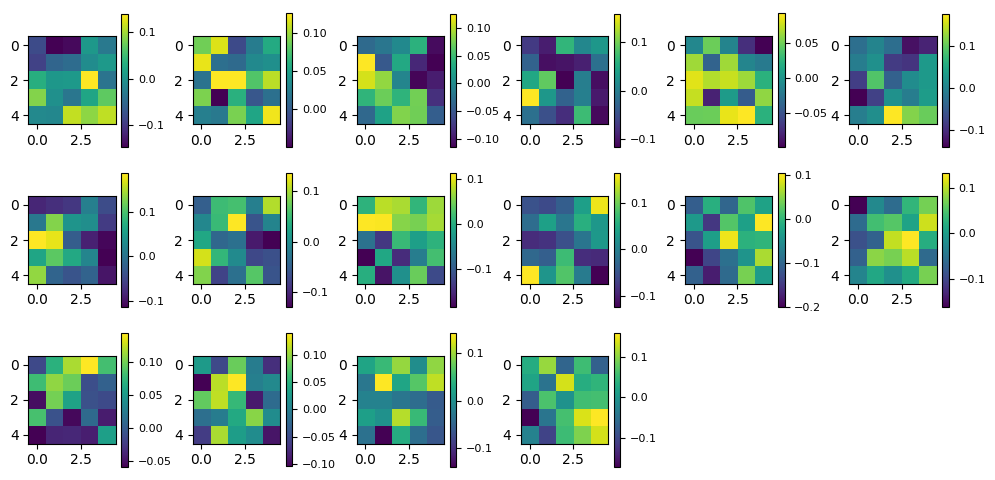

In [80]:
plt.figure(figsize=(12, 6), dpi=100)
plt.subplots_adjust(wspace=0.5)
for i in range(16):
    plt.subplot(3,6,i+1)
    plt.imshow(np.rot90(conv2_weights[:,:,0,i].T))
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

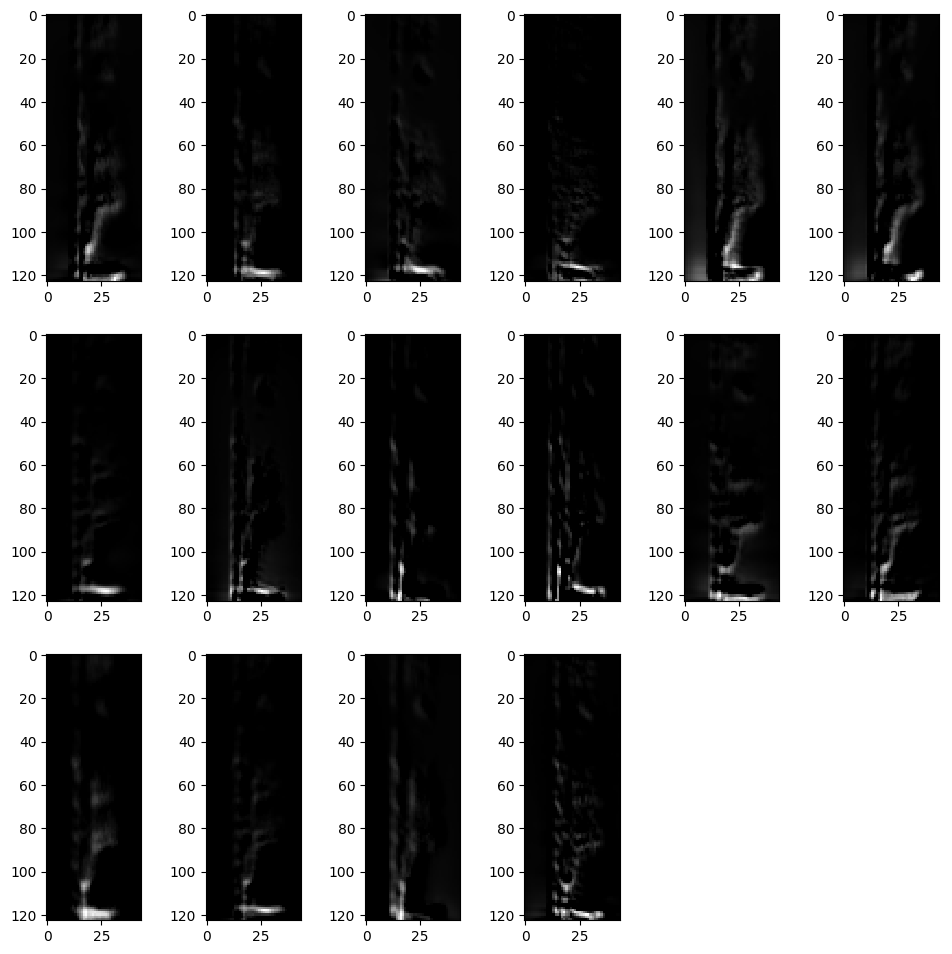

In [35]:
plt.figure(figsize=(12, 12), dpi=100)
for i in range(16):
    plt.subplot(3,6,i+1)
    plt.imshow(np.rot90(conv2_active_output[i].T), cmap='gray')

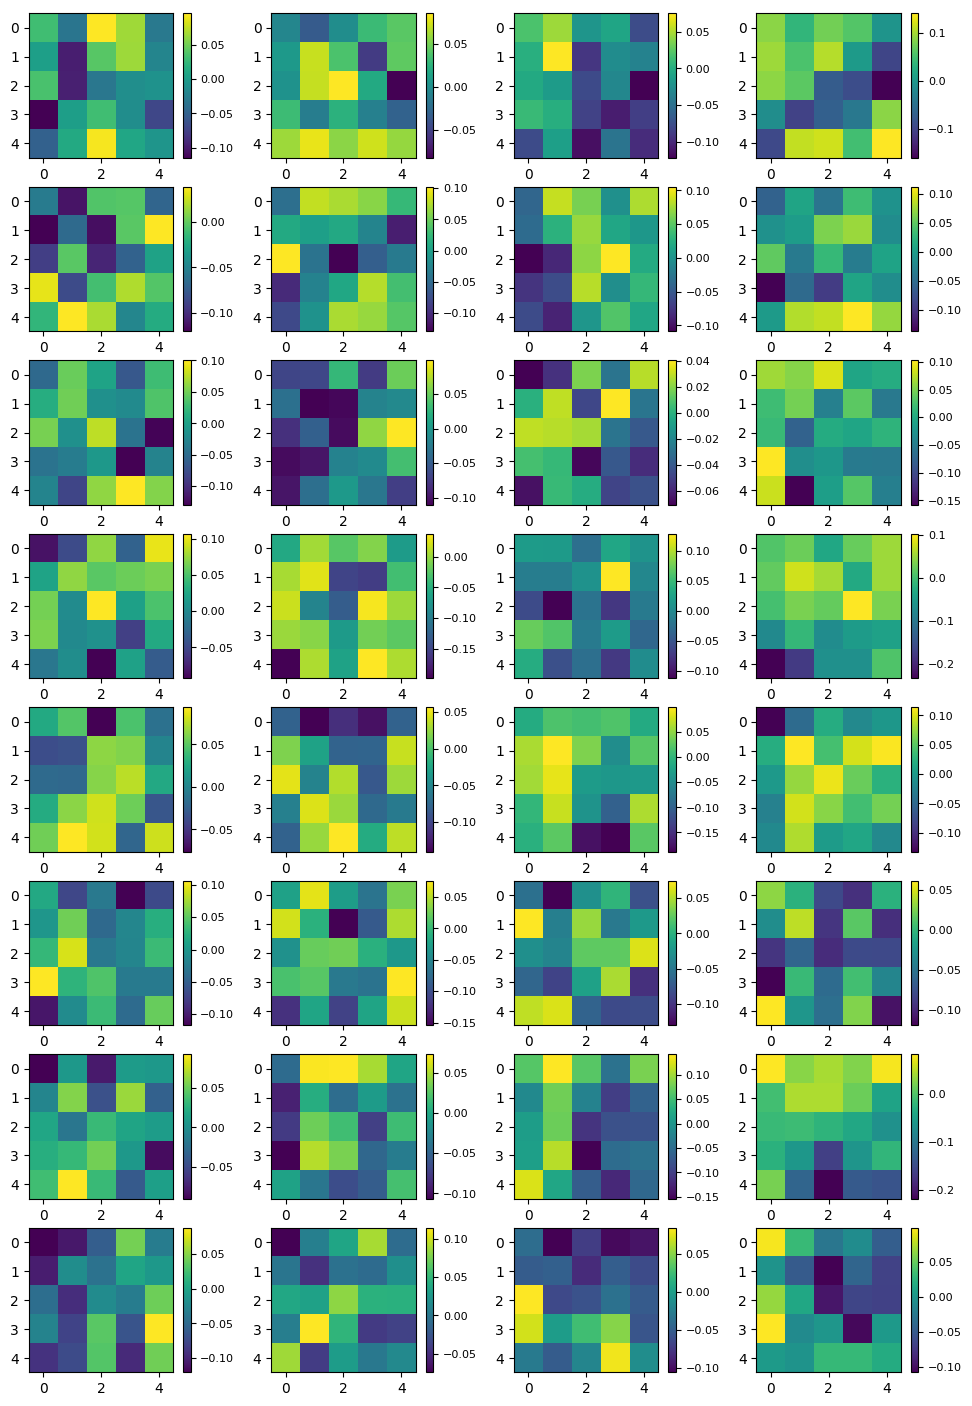

In [84]:
plt.figure(figsize=(12, 18), dpi=100)
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(np.rot90(conv3_weights[:,:,0,i].T))
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 

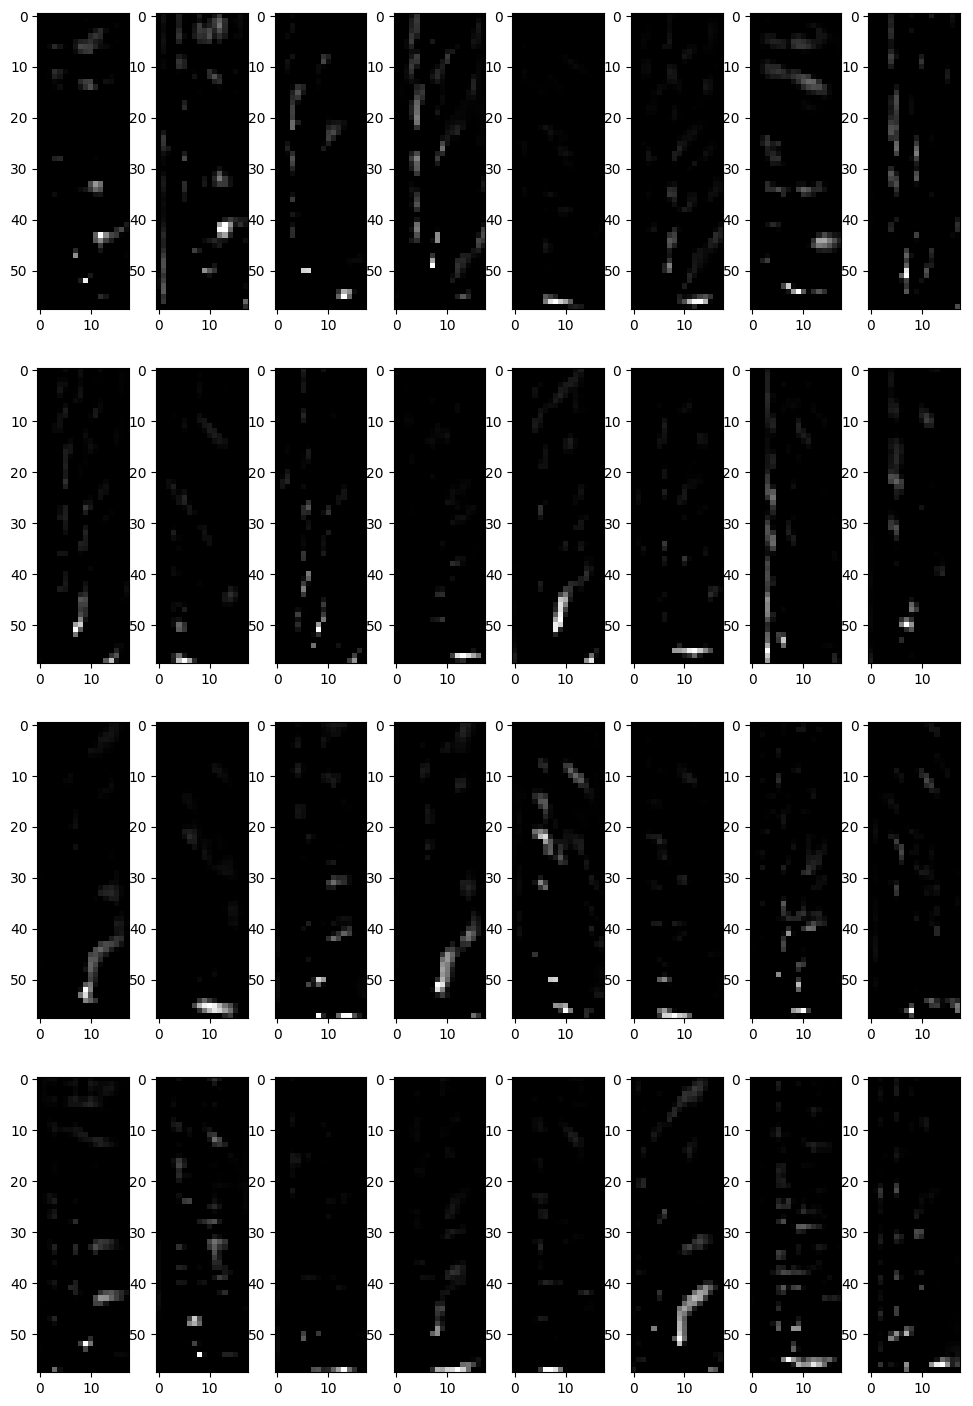

In [70]:
plt.figure(figsize=(12, 18), dpi=100)
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(np.rot90(conv3_active_output[i].T), cmap='gray')

In [ ]:
sound_path = '/users/jhlee/data/img_snd/'
root_path = '/data/01_experiment_data/image_sound/backup_sound/img_snd'
test_list = os.path.join(root_path, 'test_16words_png.txt')


file_hit = open(os.path.join(model_path, 'test_16words_png_hit.txt'),"w")
file_miss = open(os.path.join(model_path, 'test_16words_png_miss.txt'),"w")

    
## create a new session 
## and restore the model
with tf.Session(graph=g) as sess:
    load(saver, sess, 
         epoch=100, path=model_path)
    
    ### the hit/miss for the test samples
    batch_gen_test = batch_generator(X_test_centered, y_test, \
                        batch_size=64, shuffle=False)
    test_acc = []
    avg_acc = 0.0
    list_correct_preds = []
    for j, (batch_test_x, batch_test_y) in enumerate(batch_gen_test):
        feed = {'tf_x:0': batch_test_x, 'tf_y:0': batch_test_y, \
                       'fc_keep_prob:0':1.0}
        avg_acc += sess.run('accuracy:0', feed_dict=feed)
        list_correct_preds.append(sess.run('correct_preds:0', feed_dict=feed))
        
    test_acc.append(avg_acc / (j+1))
    print(' Test Acc: %7.3f' % test_acc[-1])
    print(list_correct_preds)
    
    list_correct_preds = list(itertools.chain(*list_correct_preds))
    
    ### load the list of sample and save the hit/miss sample separately
    with open(test_list, 'rt') as filelist:
        idx = 0
        for fname in filelist.read().splitlines():
            img = np.array(Image.open(os.path.join(sound_path,fname)))
            if img.shape == img_dim:
                if list_correct_preds[idx]:
                    file_hit.write(fname + '\n')
                else:
                    file_miss.write(fname + '\n')

                idx += 1

            if idx % 1000 == 0:
                print(idx)
                
        print(idx) 
    
    file_hit.close()
    file_miss.close()

In [ ]:
x = flatten(list_correct_preds)

In [ ]:
x.shape

In [ ]:
import itertools

In [ ]:
x = list(itertools.chain(*list_correct_preds))

In [ ]:
len(x)